# Signal profiles

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from math import fabs, ceil

sns.set_style("whitegrid")
# sns.set_style("white")
import os
from tqdm.auto import tqdm
from itertools import product
import os
import pyBigWig
from math import ceil
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# GSE26320 reprocessed

In [2]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_MODIFICATIONS = ['CTCF',  'H3K4me3', 'H3K4me1', 'H3K27ac', 'H3K36me3', 'H3K27me3']
# GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
GSE26320_CELLS = ['GM12878', 'K562', 'NHEK']
# GSE26320_REPS = ['rep1', 'rep2']
GSE26320_REPS = ['rep1']

## Peaks length for ENCODE dataset

# Autocorrection across all coverage - with control correction
Paper: Retrieving Chromatin Patterns from Deep Sequencing Data Using Correlation Functions
https://www.cell.com/biophysj/fulltext/S0006-3495(17)30032-2#sec2

`bwext` folder is used to create bigwig visualization by enlarging coverage to fragment size.
```
# Visualization
for F in *.bam; do echo $F; samtools index $F; bamCoverage --ignoreDuplicates --extendReads 200 -b $F -p 6 -o ${F/.bam/_ext.bw}; done
```

In [3]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows()
}

In [4]:
GSE26320_BW_PATH = os.path.join(GSE26320_PATH, 'bwext')

def r0(o, c):
    """ Correlation to estimate b """
    assert o.size == c.size
    # o_mean = o.sum() / o.size
    # c_mean = c.sum() / c.size
    # on = o - o_mean
    # cn = c - c_mean
    # return np.dot(on, cn) / sqrt(np.dot(on, on) * np.dot(cn, cn))
    return pearsonr(o, c)[0]

def rDx(dx, o1, o2):
    """ Slow shifted correlation function by formula from paper """
    assert o1.size == o2.size
    # n = o1.size
    # o1_mean = o1.sum() / o1.size
    # o2_mean = o2.sum() / o2.size
    # o1n = o1 - o1_mean
    # o2n = o2 - o2_mean
    # nominator = (1 / (2 * (n - dx))) * sum(
    #     (o1[i] - o1_mean) * (o2[i + dx] - o2_mean) + (o1[i + dx] - o1_mean) * (o2[i] - o2_mean)
    #     for i in range(n - dx)
    # )
    # denominator = (1 / n) * sqrt(np.dot(o1n, o1n) * np.dot(o2n, o2n))
    # return nominator / denominator
    return pearsonr(o1, np.roll(o2, dx))[0]

# TODO: support blacklisted regions to avoid long-distance zero coverage

def compute_autocorrelations_paper(modifications, cells, replicates, chrom_sizes, bin, ds, control='Input', bwpath=GSE26320_BW_PATH):
    correlations = []
    for mod, cell, rep in tqdm(list(product(modifications, cells, replicates))):
        bwfile = next((f for f in os.listdir(bwpath) if '.bw' in f and mod in f and cell in f and rep in f), None)
        bwcfile = next((f for f in os.listdir(bwpath) if '.bw' in f and control in f and cell in f and rep in f), None)
        if bwfile is None or bwcfile is None:
            continue
        print(mod, cell, rep, bwfile, bwcfile)
        for chr, chr_size in tqdm(chrom_sizes.items()):
            chr_size = min(chr_size, 100_000_000)
            print(f'Computing {mod} {cell} {rep} binned {bin}bp coverage correlations on chr {chr} {chr_size}')
            with pyBigWig.open(os.path.join(bwpath, bwfile)) as bw:
                coverage = np.asarray(bw.stats(chr, nBins=(int(ceil(chr_size / bin))), exact=True, type='sum'))
            with pyBigWig.open(os.path.join(bwpath, bwcfile)) as bwc:
                coveragec = np.asarray(bwc.stats(chr, nBins=(int(ceil(chr_size / bin))), exact=True, type='sum'))
            # The coverage was initially calculated for each chromosome by extending the reads to
            # fragment length, yielding a histogram with the genomic coordinate on the x axis
            # and the number of reads per basepair on the y axis.

            print(f'{chr} Coverage mln signal: {coverage.sum()} control: {coveragec.sum()}')
            # First, the normalized coverage of the control Cnorm and of the specific IP Anorm
            # were obtained by dividing by input signal I. Positions with zero input coverage were neglected.
            # Subsequently, the coverage at these positions was set to the respective average value
            # that was calculated for the remaining positions, thus eliminating fluctuations and
            # corresponding contributions to the correlation coefficient from these positions.
            coverage_mean = coverage.sum() / sum(coverage > 0)
            coveragec_mean = coveragec.sum() / sum(coveragec > 0)
            print(f'Mean signal {coverage_mean} control {coveragec_mean}')
            coverage[coverage == 0] = coverage_mean
            coveragec[coveragec == 0] = coveragec_mean
            coverage = coverage / coverage_mean
            coveragec = coveragec / coveragec_mean
            # In the next step, nonspecific background signal was removed to obtain the
            # normalized read occupancy O = Anorm − b × Cnorm
            # The parameter b quantifies the contribution of the control signal present as
            # background in the sample (IP).
            # To estimate b, we minimized the absolute value of the Pearson correlation coefficient r0 at
            # zero shift distance between the normalized occupancy O and the control coverage Cnorm.
            # For the minimization procedure, b was changed between 0 and 1.
            print('Estimating b between 0 and 1')
            stepB = 0.01
            bs = np.linspace(0, 1, num = int(1 / stepB) + 1)
            bCs = [fabs(r0(coverage - b * coveragec, coveragec)) for b in bs]
            bI = np.argmin(bCs)
            b = bs[bI]
            print(f'I={bI}, b={b}, correlation={bCs[bI]}')
            coverageo = coverage - b * coveragec
            print('Computing autocorrelations')
            for d in ds:
                corr, pval = rDx(d, coverageo, coverageo), None
                correlations.append((mod, cell, rep, bwfile, chr, coverage_mean, coveragec_mean, b,
                                     d * bin, corr, pval))
    return pd.DataFrame(
        columns=['modification', 'cell', 'replicate', 'file', 'chr', 'coverage mean', 'control mean', 'b',
                 'd', 'correlation', 'pvalue'],
        data=correlations
    )

In [5]:
# To sample the correlation function in a quasi-logarithmic manner (33),
# profiles were binned by a factor of two after 25 shift operations to double the step size.
# To preserve high resolution for small shift distances, the first binning operation was carried
# out at a shift of Δx = 50 bp.
BIN = 50
DS = list(range(0, int(5000 / BIN))) + \
     list(range(int(5000 / BIN), int(100_000 / BIN), int(1000 / BIN))) + \
     list(range(int(100_000 / BIN), int(1_000_100 / BIN), int(100_000 / BIN)))
print(len(DS))

205


In [6]:
df_correlations_paper = compute_autocorrelations_paper(GSE26320_MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS,
                                                       {'chr22': CHROM_SIZES['chr22']}, BIN, DS)
df_correlations_paper.sample(3)

  0%|          | 0/18 [00:00<?, ?it/s]

H3K4me3 GM12878 rep1 GSM646326_GM12878_H3K4me3_rep1_ext.bw GSM646332_GM12878_Input_rep1_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me3 GM12878 rep1 binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 23028750.0 control: 15885900.0
Mean signal 95.13575034495294 control 56.78646496132233
Estimating b between 0 and 1
I=8, b=0.08, correlation=0.0009096348275260341
Computing autocorrelations
H3K4me3 K562 rep1 GSM646444_K562_H3K4me3_rep1_ext.bw GSM646452_K562_Input_rep1_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me3 K562 rep1 binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 44958750.0 control: 36161500.0
Mean signal 149.287246476909 control 94.17302533920154
Estimating b between 0 and 1
I=62, b=0.62, correlation=0.0008004138093128058
Computing autocorrelations
H3K4me3 NHEK rep1 GSM646466_NHEK_H3K4me3_rep1_ext.bw GSM646472_NHEK_Input_rep1_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me3 NHEK rep1 binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 31790350.0 control: 21004750.0
Mean signal 91.69464490709494 control 62.7792672028597
Estimating b between 0 and 1
I=0, b=0.0, correlation=0.0013718250217900415
Computing autocorrelations
H3K4me1 GM12878 rep1 GSM646322_GM12878_H3K4me1_rep1_ext.bw GSM646332_GM12878_Input_rep1_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me1 GM12878 rep1 binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 44038500.0 control: 15885900.0
Mean signal 130.14664160578764 control 56.78646496132233
Estimating b between 0 and 1
I=12, b=0.12, correlation=0.0002396740453753073
Computing autocorrelations
H3K4me1 K562 rep1 GSM646440_K562_H3K4me1_rep1_ext.bw GSM646452_K562_Input_rep1_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me1 K562 rep1 binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 51614500.0 control: 36161500.0
Mean signal 166.7662890708299 control 94.17302533920154
Estimating b between 0 and 1
I=66, b=0.66, correlation=0.0017007538694378335
Computing autocorrelations
H3K4me1 NHEK rep1 GSM646462_NHEK_H3K4me1_rep1_ext.bw GSM646472_NHEK_Input_rep1_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me1 NHEK rep1 binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 40679500.0 control: 21004750.0
Mean signal 147.89426230104195 control 62.7792672028597
Estimating b between 0 and 1
I=3, b=0.03, correlation=0.0006738451719398615
Computing autocorrelations
H3K27ac GM12878 rep1 GSM646316_GM12878_H3K27ac_rep1_ext.bw GSM646332_GM12878_Input_rep1_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27ac GM12878 rep1 binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 31052350.0 control: 15885900.0
Mean signal 154.5831300590408 control 56.78646496132233
Estimating b between 0 and 1
I=11, b=0.11, correlation=5.739859111349643e-05
Computing autocorrelations
H3K27ac K562 rep1 GSM646434_K562_H3K27ac_rep1_ext.bw GSM646452_K562_Input_rep1_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27ac K562 rep1 binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 55813350.0 control: 36161500.0
Mean signal 169.41371983609045 control 94.17302533920154
Estimating b between 0 and 1
I=62, b=0.62, correlation=0.0012880562247501934
Computing autocorrelations
H3K27ac NHEK rep1 GSM646456_NHEK_H3K27ac_rep1_ext.bw GSM646472_NHEK_Input_rep1_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27ac NHEK rep1 binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 40012750.0 control: 21004750.0
Mean signal 181.8802700061365 control 62.7792672028597
Estimating b between 0 and 1
I=2, b=0.02, correlation=0.0007973174162174577
Computing autocorrelations
H3K36me3 GM12878 rep1 GSM646320_GM12878_H3K36me3_rep1_ext.bw GSM646332_GM12878_Input_rep1_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K36me3 GM12878 rep1 binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 36546550.0 control: 15885900.0
Mean signal 101.14816075634415 control 56.78646496132233
Estimating b between 0 and 1
I=5, b=0.05, correlation=0.0011292736448147466
Computing autocorrelations
H3K36me3 K562 rep1 GSM646438_K562_H3K36me3_rep1_ext.bw GSM646452_K562_Input_rep1_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K36me3 K562 rep1 binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 43598950.0 control: 36161500.0
Mean signal 133.64523080412837 control 94.17302533920154
Estimating b between 0 and 1
I=51, b=0.51, correlation=0.00216218601227329
Computing autocorrelations
H3K27me3 GM12878 rep1 GSM646318_GM12878_H3K27me3_rep1_ext.bw GSM646332_GM12878_Input_rep1_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27me3 GM12878 rep1 binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 24176400.0 control: 15885900.0
Mean signal 77.65247750858384 control 56.78646496132233
Estimating b between 0 and 1
I=2, b=0.02, correlation=0.003417248119935444
Computing autocorrelations
H3K27me3 K562 rep1 GSM646436_K562_H3K27me3_rep1_ext.bw GSM646452_K562_Input_rep1_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27me3 K562 rep1 binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 33355100.0 control: 36161500.0
Mean signal 102.43723415690309 control 94.17302533920154
Estimating b between 0 and 1
I=42, b=0.42, correlation=0.000818786095449036
Computing autocorrelations
H3K27me3 NHEK rep1 GSM646458_NHEK_H3K27me3_rep1_ext.bw GSM646472_NHEK_Input_rep1_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27me3 NHEK rep1 binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 29389750.0 control: 21004750.0
Mean signal 89.23398996830177 control 62.7792672028597
Estimating b between 0 and 1
I=0, b=0.0, correlation=9.332793743531582e-05
Computing autocorrelations


,modification,cell,replicate,file,chr,coverage mean,control mean,b,d,correlation,pvalue
1798,H3K27ac,NHEK,rep1,GSM646456_NHEK_H3K27ac_rep1_ext.bw,chr22,181.880270,62.779267,0.02,63000,0.019535,None
2038,H3K36me3,GM12878,rep1,GSM646320_GM12878_H3K36me3_rep1_ext.bw,chr22,101.148161,56.786465,0.05,98000,0.039520,None
520,H3K4me3,NHEK,rep1,GSM646466_NHEK_H3K4me3_rep1_ext.bw,chr22,91.694645,62.779267,0.00,15000,0.025177,None


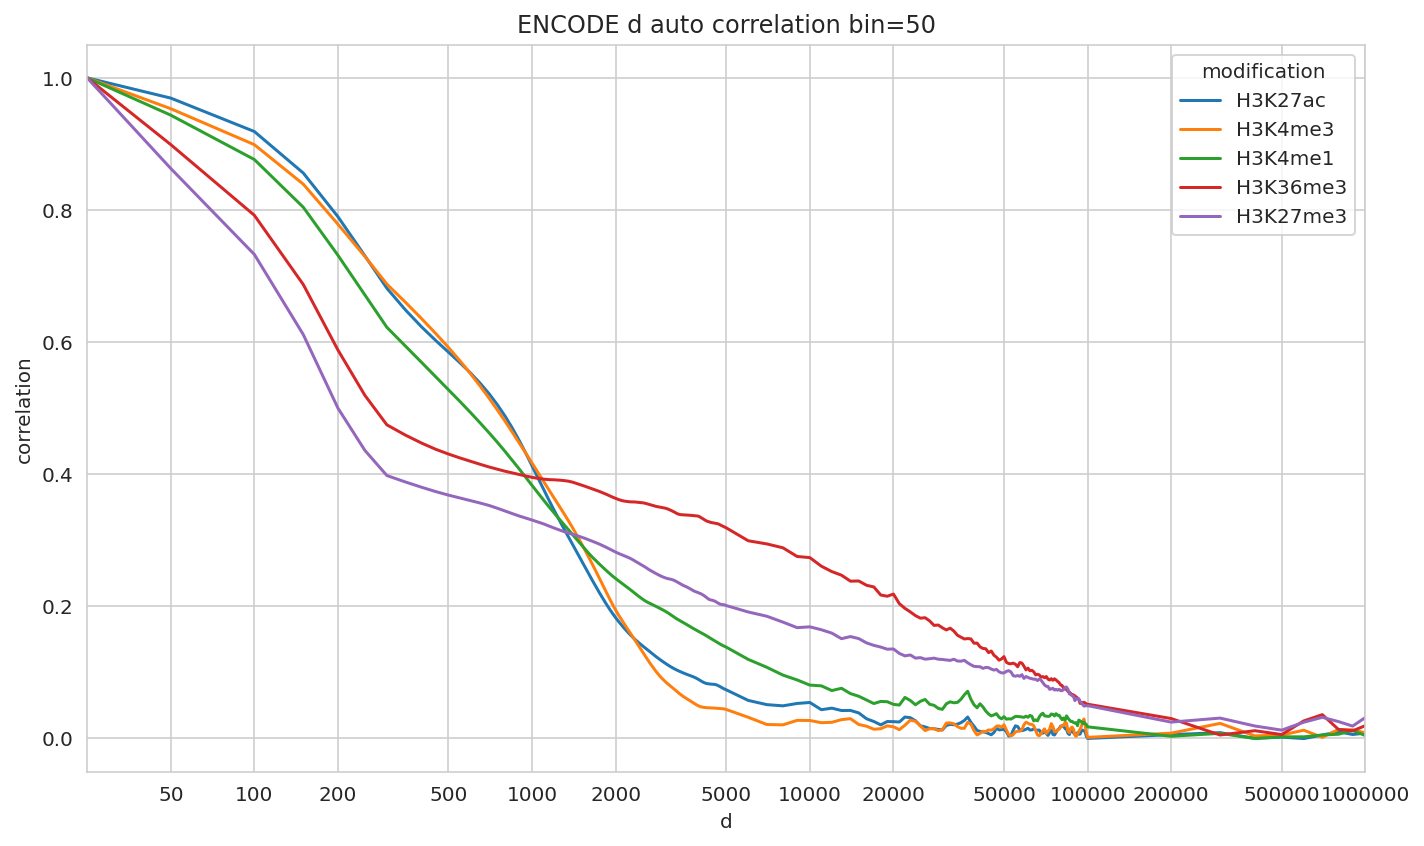

In [7]:
# plt.figure(figsize=(5, 3))
plt.figure(figsize=(10, 6))
ax = plt.axes()
# Show aggregated data, since we don't want error plots
t = df_correlations_paper.copy()
t.loc[t['d'] == 0, 'd'] = BIN / 2
t = t[['modification', 'd', 'correlation']].groupby(['modification', 'd']).mean().reset_index()
g_results = sns.lineplot(data=t, x="d", y="correlation", hue="modification",
                         hue_order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'])
ticks = [1, 20, 50, 100, 200, 500, 1000, 2000, 5000,
         10_000, 20_000, 50_000, 100_000, 200_000, 500_000, 1_000_000]
# ticks = [100, 1000, 10_000, 100_000, 1_000_000]

g_results.set(xscale='log')
g_results.set(xticks=ticks)
g_results.set(xticklabels=ticks)
ax.title.set_text(f'ENCODE d auto correlation bin={BIN}')
ax.set_xlim(BIN / 2, 1_000_000)
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH}/pics/paper_signal_correlation.pdf', bbox_inches='tight', dpi=300)
plt.show()

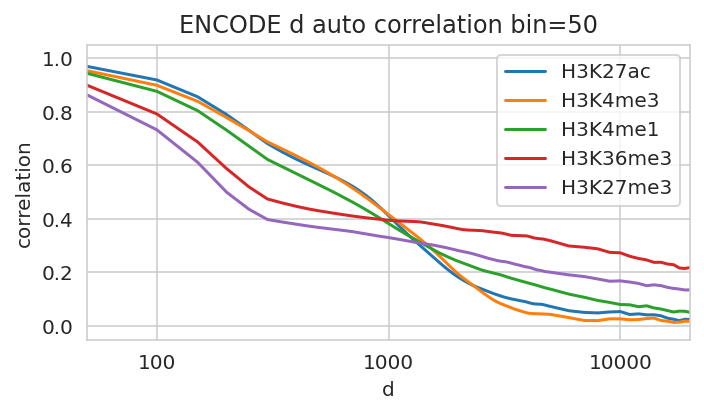

In [8]:
plt.figure(figsize=(5, 3))
# plt.figure(figsize=(10, 6))
ax = plt.axes()
g_results = sns.lineplot(data=t, x="d", y="correlation", hue="modification",
             hue_order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'])
ticks = [100, 1000, 10_000]
g_results.set(xscale='log')
g_results.set(xticks=ticks)
g_results.set(xticklabels=ticks)
ax.set_xlim(50, 20_000)
ax.title.set_text(f'ENCODE d auto correlation bin={BIN}')
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH}/pics/paper_signal_correlation_zoom.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Signal profile along peaks

In [9]:
RANGE = 50_000
BIN = 50
BINS = int(RANGE / BIN)
PEAKS = 1000

In [10]:
GSE26320_SPAN_PATH = os.path.join(GSE26320_PATH, 'span')
GSE26320_BW_PATH = os.path.join(GSE26320_PATH, 'bwext')

RANGE = 10000
BIN = 50
BINS = int(RANGE / BIN)
PEAKS = 100

def intersect(c1, s1, e1, c2, s2, e2):
    return c1 == c2 and (s1 <= s2 < e1 or s1 <= e2 - 1 < e2)

def signal_peaks_profile(modifications, cells, replicates, peakspath=GSE26320_SPAN_PATH, bwpath=GSE26320_BW_PATH,
                         control='Input'):
    profiles = []
    for mod, cell, rep in tqdm(list(product(modifications, cells, replicates))):
        peaksfile = next((f for f in os.listdir(peakspath) if mod in f and cell in f and rep in f), None)
        bwfile = next((f for f in os.listdir(bwpath) if '.bw' in f and mod in f and cell in f and rep in f), None)
        bwcfile = next((f for f in os.listdir(bwpath) if '.bw' in f and control in f and cell in f and rep in f), None)
        if peaksfile is None or bwfile is None:
            continue
        print(mod, cell, rep, peaksfile, bwfile)
        # Load peaks file and sort by score
        peaksfile_df = pd.read_csv(os.path.join(peakspath, peaksfile), sep='\t',
                                   names=['chr', 'start', 'end', '4', '5', '6', '7', '8', 'score'])
        peaksfile_df = peaksfile_df[['chr', 'start', 'end', 'score']].copy()
        peaksfile_df.sort_values(by=['score'], ascending=False, inplace=True)
        # Ensure that peaks do not intersect and doesn't contain any significant peaks
        intersects = [t for _, t in peaksfile_df.head(PEAKS)[['chr', 'start', 'end']].iterrows()]
        added = 0
        with pyBigWig.open(os.path.join(bwpath, bwfile)) as bw:
            with pyBigWig.open(os.path.join(bwpath, bwcfile)) as bwc:
                total_coverage = sum(bw.stats(f'chr{i}', exact=True)[0] for i in range(1, 22))
                total_coveragec = sum(bwc.stats(f'chr{i}', exact=True)[0] for i in range(1, 22))
                # print(total_coverage)
                for _, (chr, start, end, score) in peaksfile_df.iterrows():
                    # No more than single intersection
                    if sum(intersect(chr, start, end, c, s, e) for c, s, e in intersects) > 1:
                        continue
                    # Find summit for narrow peak, center of peak for broad
                    if mod in ['CTCF', 'H3K27ac', 'H3K4me3']:
                        nBins = min(BINS, int((end - start) / 20))
                        stats = bw.stats(chr, start, end, nBins=nBins, exact=True)
                        max_offset = start + (np.argmax(stats) + 0.5) * (end - start) / nBins
                        r_start = int(max_offset  - RANGE / 2)
                    else:
                        r_start = int((start + end) / 2 - RANGE / 2)
                    if r_start < 0:
                        continue
                    r_end = r_start + RANGE
                    # Check that no peak intersect others
                    if sum(intersect(chr, r_start, r_end, c, s, e) for c, s, e in intersects) > 1:
                        continue
                    intersects.append((chr, r_start, r_end))
                    # Analyse signal and control coverage
                    try:
                        for i, cov in enumerate(bw.stats(chr, r_start, r_end, nBins=BINS, exact=True)):
                            profiles.append((mod, cell, rep, added, (-BINS / 2 + i) * BIN, cov / total_coverage))
                        for i, cov in enumerate(bwc.stats(chr, r_start, r_end, nBins=BINS, exact=True)):
                            profiles.append((control, cell, rep, added, (-BINS / 2 + i) * BIN, cov / total_coveragec))
                    except:
                        pass
                    added += 1
                    if added == PEAKS:
                        break

    return pd.DataFrame(columns=['modification', 'cell', 'replicate', 'peak', 'x', 'coverage'], data=profiles)

In [11]:
df_gse26320_cov = signal_peaks_profile(GSE26320_MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_gse26320_cov

  0%|          | 0/18 [00:00<?, ?it/s]

H3K4me3 GM12878 rep1 GSM646326_GM12878_H3K4me3_rep1_100_0.05_3.peak GSM646326_GM12878_H3K4me3_rep1_ext.bw
H3K4me3 K562 rep1 GSM646444_K562_H3K4me3_rep1_100_0.05_3.peak GSM646444_K562_H3K4me3_rep1_ext.bw
H3K4me3 NHEK rep1 GSM646466_NHEK_H3K4me3_rep1_100_0.05_3.peak GSM646466_NHEK_H3K4me3_rep1_ext.bw
H3K4me1 GM12878 rep1 GSM646322_GM12878_H3K4me1_rep1_100_0.05_3.peak GSM646322_GM12878_H3K4me1_rep1_ext.bw
H3K4me1 K562 rep1 GSM646440_K562_H3K4me1_rep1_100_0.05_3.peak GSM646440_K562_H3K4me1_rep1_ext.bw
H3K4me1 NHEK rep1 GSM646462_NHEK_H3K4me1_rep1_100_0.05_3.peak GSM646462_NHEK_H3K4me1_rep1_ext.bw
H3K27ac GM12878 rep1 GSM646316_GM12878_H3K27ac_rep1_100_0.05_3.peak GSM646316_GM12878_H3K27ac_rep1_ext.bw
H3K27ac K562 rep1 GSM646434_K562_H3K27ac_rep1_100_0.05_3.peak GSM646434_K562_H3K27ac_rep1_ext.bw
H3K27ac NHEK rep1 GSM646456_NHEK_H3K27ac_rep1_100_0.05_3.peak GSM646456_NHEK_H3K27ac_rep1_ext.bw
H3K36me3 GM12878 rep1 GSM646320_GM12878_H3K36me3_rep1_100_0.05_3.peak GSM646320_GM12878_H3K36me3_rep

,modification,cell,replicate,peak,x,coverage
0,H3K4me3,GM12878,rep1,0,-5000.0,0.818836
1,H3K4me3,GM12878,rep1,0,-4950.0,1.098964
2,H3K4me3,GM12878,rep1,0,-4900.0,1.307265
3,H3K4me3,GM12878,rep1,0,-4850.0,1.296490
4,H3K4me3,GM12878,rep1,0,-4800.0,1.106147
...,...,...,...,...,...,...
559995,Input,NHEK,rep1,99,4750.0,0.000000
559996,Input,NHEK,rep1,99,4800.0,0.000000
559997,Input,NHEK,rep1,99,4850.0,0.000000
559998,Input,NHEK,rep1,99,4900.0,0.000000


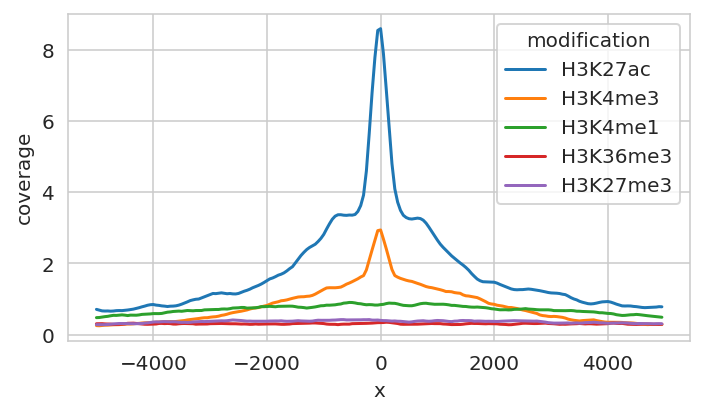

In [12]:
plt.figure(figsize=(5, 3))
# Show aggregated data, since we don't want error plots
t = df_gse26320_cov[['modification', 'x', 'coverage']].groupby(['modification', 'x']).mean().reset_index()
sns.lineplot(data=t, x="x", y="coverage", hue="modification", err_style=None,
             hue_order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'])
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH}/pics/peaks_profile.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Peaks densities

In [13]:
GSE26320_SPAN_PATH = os.path.join(GSE26320_PATH, 'span')
GSE26320_BW_PATH = os.path.join(GSE26320_PATH, 'bwext')

data = []
for mod, cell, rep in tqdm(list(product(GSE26320_MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS))):
    peaksfile = next((f for f in os.listdir(GSE26320_SPAN_PATH) if mod in f and cell in f and rep in f), None)
    bwfile = next((f for f in os.listdir(GSE26320_BW_PATH) if '.bw' in f and mod in f and cell in f and rep in f), None)
    bwcfile = next((f for f in os.listdir(GSE26320_BW_PATH) if '.bw' in f and 'Input' in f and cell in f and rep in f),
                   None)
    if peaksfile is None or bwfile is None or bwcfile is None:
        continue
    print(mod, cell, rep, peaksfile, bwfile, bwcfile)

    # Load peaks file and sort by score
    peaksfile_df = pd.read_csv(os.path.join(GSE26320_SPAN_PATH, peaksfile), sep='\t',
                               names=['chr', 'start', 'end', '4', '5', '6', '7', '8', 'score'])
    with pyBigWig.open(os.path.join(GSE26320_BW_PATH, bwfile)) as bw:
        with pyBigWig.open(os.path.join(GSE26320_BW_PATH, bwcfile)) as bwc:
            # Resort top scored peaks by density and start with the most dense ones
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys()) / 1e6
            total_coveragec = sum(bwc.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys()) / 1e6
            for _, (chr, start, end) in peaksfile_df[['chr', 'start', 'end']].iterrows():
                peak_coverage = bw.stats(chr, start, end, exact=True, type='sum')[0]
                peak_coveragec = bwc.stats(chr, start, end, exact=True, type='sum')[0]
                data.append((mod, cell, rep, total_coverage, total_coveragec,
                             f'{chr}:{start}-{end}', end - start, peak_coverage, peak_coveragec))

gse26320_peak_coverages_df = pd.DataFrame(
    columns=['modification', 'cell', 'replicate', 'total_signal_coverage', 'total_control_coverage',
             'peak', 'length', 'signal_coverage', 'control_coverage'],
    data=data
)
del data
gse26320_peak_coverages_df

  0%|          | 0/18 [00:00<?, ?it/s]

H3K4me3 GM12878 rep1 GSM646326_GM12878_H3K4me3_rep1_100_0.05_3.peak GSM646326_GM12878_H3K4me3_rep1_ext.bw GSM646332_GM12878_Input_rep1_ext.bw
H3K4me3 K562 rep1 GSM646444_K562_H3K4me3_rep1_100_0.05_3.peak GSM646444_K562_H3K4me3_rep1_ext.bw GSM646452_K562_Input_rep1_ext.bw
H3K4me3 NHEK rep1 GSM646466_NHEK_H3K4me3_rep1_100_0.05_3.peak GSM646466_NHEK_H3K4me3_rep1_ext.bw GSM646472_NHEK_Input_rep1_ext.bw
H3K4me1 GM12878 rep1 GSM646322_GM12878_H3K4me1_rep1_100_0.05_3.peak GSM646322_GM12878_H3K4me1_rep1_ext.bw GSM646332_GM12878_Input_rep1_ext.bw
H3K4me1 K562 rep1 GSM646440_K562_H3K4me1_rep1_100_0.05_3.peak GSM646440_K562_H3K4me1_rep1_ext.bw GSM646452_K562_Input_rep1_ext.bw
H3K4me1 NHEK rep1 GSM646462_NHEK_H3K4me1_rep1_100_0.05_3.peak GSM646462_NHEK_H3K4me1_rep1_ext.bw GSM646472_NHEK_Input_rep1_ext.bw
H3K27ac GM12878 rep1 GSM646316_GM12878_H3K27ac_rep1_100_0.05_3.peak GSM646316_GM12878_H3K27ac_rep1_ext.bw GSM646332_GM12878_Input_rep1_ext.bw
H3K27ac K562 rep1 GSM646434_K562_H3K27ac_rep1_100_0.05

,modification,cell,replicate,total_signal_coverage,total_control_coverage,peak,length,signal_coverage,control_coverage
0,H3K4me3,GM12878,rep1,1575.884116,1404.343019,chr1:777001-779944,2943,11103.0,500.0
1,H3K4me3,GM12878,rep1,1575.884116,1404.343019,chr1:826610-827469,859,3362.0,250.0
2,H3K4me3,GM12878,rep1,1575.884116,1404.343019,chr1:905217-905653,436,2992.0,0.0
3,H3K4me3,GM12878,rep1,1575.884116,1404.343019,chr1:957651-959198,1547,17225.0,897.0
4,H3K4me3,GM12878,rep1,1575.884116,1404.343019,chr1:960989-961367,378,1673.0,0.0
...,...,...,...,...,...,...,...,...,...
669708,H3K27me3,NHEK,rep1,1787.623735,1984.273617,chrX:154322855-154323280,425,1275.0,130.0
669709,H3K27me3,NHEK,rep1,1787.623735,1984.273617,chrX:154325454-154329646,4192,10022.0,4842.0
669710,H3K27me3,NHEK,rep1,1787.623735,1984.273617,chrX:154594717-154595368,651,1437.0,433.0
669711,H3K27me3,NHEK,rep1,1787.623735,1984.273617,chrX:154675525-154676682,1157,2207.0,32.0


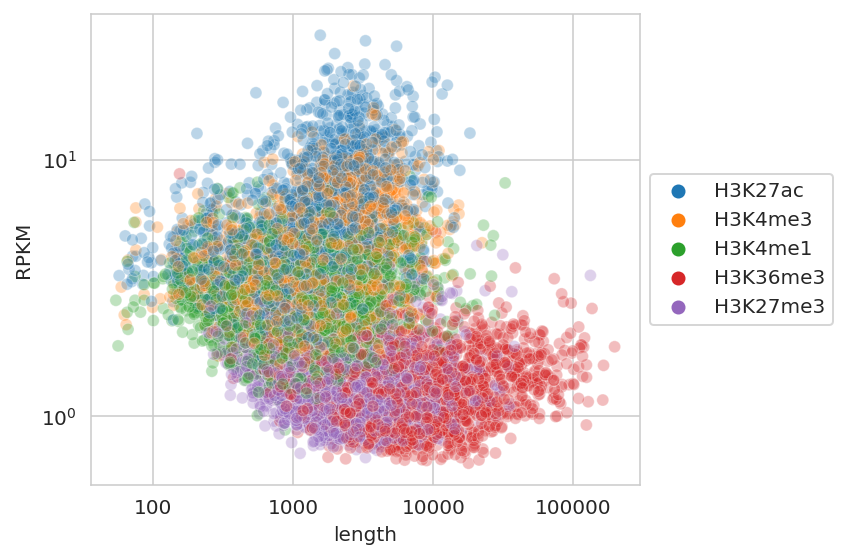

In [14]:
plt.figure(figsize=(6, 4))
t = pd.concat([gse26320_peak_coverages_df[gse26320_peak_coverages_df['modification'] == m].sample(2_000)
               for m in gse26320_peak_coverages_df['modification'].unique()]).reset_index(drop=True).sample(frac=1).reset_index(drop=True)
t['RPKM'] = t['signal_coverage'] / t['length'] * 1e3
t['RPKM'] /= t['total_signal_coverage']
t['RPKM'].clip(lower=0.2, inplace=True)
t['length'].clip(upper=3e5, inplace=True)
ticks = [100, 1000, 10_000, 100_000]
g_results = sns.scatterplot(data=t, x='length', y='RPKM', hue='modification', alpha=0.3,
                            hue_order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'])
# g_results = sns.kdeplot(data=t, x='length', y='RPKM', hue='modification', alpha=0.3,
#                         hue_order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'], fill='true')

g_results.set(xscale='log')
g_results.set(xticks=ticks)
g_results.set(xticklabels=ticks)
g_results.set(yscale='log')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH}/pics/peaks_length_vs_rpkm.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Autocorrelations - without control correction
Simplified autocorrelation computation

In [15]:
def compute_autocorrelations(modifications, cells, replicates, chrom_sizes, bin, ds, bwpath=GSE26320_BW_PATH):
    correlations = []
    for mod, cell, rep in tqdm(list(product(modifications, cells, replicates))):
        bwfile = next((f for f in os.listdir(bwpath) if '.bw' in f and mod in f and cell in f and rep in f), None)
        if bwfile is None:
            continue
        print(mod, cell, rep, bwfile)
        print(f'Computing binned coverage correlations')
        with pyBigWig.open(os.path.join(bwpath, bwfile)) as bw:
            # Some chromosomes may be missing
            total_coverage = 0
            for chr in CHROM_SIZES.keys():
                try:
                    total_coverage += bw.stats(chr, exact=True, type='sum')[0]
                except:
                    pass
            total_coverage = total_coverage / 1e6
            print(f'Signal coverage mln {total_coverage}')
            for chr, chr_size in tqdm(chrom_sizes.items()):
                chr_size = min(chr_size, 100_000_000)
                print(f'Computing {mod} {cell} binned {bin}bp coverage correlations on chr {chr} {chr_size}')
                # TODO: support blacklisted regions to avoid long-distance zero coverage
                coverage = np.asarray(bw.stats(chr, 0, chr_size, nBins=(int(ceil((chr_size) / bin))),
                                               exact=True, type='sum'))
                # Ignore non-covered regions
                coverage = coverage[coverage > 0]
                for d in ds:
                    corr, pval = pearsonr(coverage, np.roll(coverage, d))
                    correlations.append((mod, cell, rep, bwfile, chr, d * bin, corr, pval))
    return pd.DataFrame(
        columns=['modification', 'cell', 'replicate', 'file', 'chr', 'd', 'correlation', 'pvalue'],
        data=correlations
    )

In [16]:
# To sample the correlation function in a quasi-logarithmic manner (33),
# profiles were binned by a factor of two after 25 shift operations to double the step size.
# To preserve high resolution for small shift distances, the first binning operation was carried
# out at a shift of Δx = 50 bp.
BIN = 50
DS = list(range(0, int(5000 / BIN))) + \
     list(range(int(5000 / BIN), int(100_000 / BIN), int(1000 / BIN))) + \
     list(range(int(100_000 / BIN), int(1_000_100 / BIN), int(100_000 / BIN)))
print(len(DS))

205


In [17]:
df_correlations = compute_autocorrelations(['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3', 'Input'],
                                           GSE26320_CELLS, GSE26320_REPS, {'chr22': CHROM_SIZES['chr22']}, BIN, DS)
df_correlations

  0%|          | 0/18 [00:00<?, ?it/s]

H3K27ac GM12878 rep1 GSM646316_GM12878_H3K27ac_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 1686.6524


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27ac GM12878 binned 50bp coverage correlations on chr chr22 50818468
H3K27ac K562 rep1 GSM646434_K562_H3K27ac_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 2536.952943


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27ac K562 binned 50bp coverage correlations on chr chr22 50818468
H3K27ac NHEK rep1 GSM646456_NHEK_H3K27ac_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 2141.886981


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27ac NHEK binned 50bp coverage correlations on chr chr22 50818468
H3K4me3 GM12878 rep1 GSM646326_GM12878_H3K4me3_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 1575.884116


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me3 GM12878 binned 50bp coverage correlations on chr chr22 50818468
H3K4me3 K562 rep1 GSM646444_K562_H3K4me3_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 2825.559691


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me3 K562 binned 50bp coverage correlations on chr chr22 50818468
H3K4me3 NHEK rep1 GSM646466_NHEK_H3K4me3_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 1901.941844


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me3 NHEK binned 50bp coverage correlations on chr chr22 50818468
H3K4me1 GM12878 rep1 GSM646322_GM12878_H3K4me1_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 2662.735448


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me1 GM12878 binned 50bp coverage correlations on chr chr22 50818468
H3K4me1 K562 rep1 GSM646440_K562_H3K4me1_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 2283.205836


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me1 K562 binned 50bp coverage correlations on chr chr22 50818468
H3K4me1 NHEK rep1 GSM646462_NHEK_H3K4me1_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 2121.32456


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me1 NHEK binned 50bp coverage correlations on chr chr22 50818468
H3K36me3 GM12878 rep1 GSM646320_GM12878_H3K36me3_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 2413.993337


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K36me3 GM12878 binned 50bp coverage correlations on chr chr22 50818468
H3K36me3 K562 rep1 GSM646438_K562_H3K36me3_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 2224.696209


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K36me3 K562 binned 50bp coverage correlations on chr chr22 50818468
H3K27me3 GM12878 rep1 GSM646318_GM12878_H3K27me3_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 2467.762347


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27me3 GM12878 binned 50bp coverage correlations on chr chr22 50818468
H3K27me3 K562 rep1 GSM646436_K562_H3K27me3_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 2235.403346


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27me3 K562 binned 50bp coverage correlations on chr chr22 50818468
H3K27me3 NHEK rep1 GSM646458_NHEK_H3K27me3_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 1787.623735


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27me3 NHEK binned 50bp coverage correlations on chr chr22 50818468
Input GM12878 rep1 GSM646332_GM12878_Input_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 1404.343019


  0%|          | 0/1 [00:00<?, ?it/s]

Computing Input GM12878 binned 50bp coverage correlations on chr chr22 50818468
Input K562 rep1 GSM646452_K562_Input_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 2502.291954


  0%|          | 0/1 [00:00<?, ?it/s]

Computing Input K562 binned 50bp coverage correlations on chr chr22 50818468
Input NHEK rep1 GSM646472_NHEK_Input_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 1984.273617


  0%|          | 0/1 [00:00<?, ?it/s]

Computing Input NHEK binned 50bp coverage correlations on chr chr22 50818468


,modification,cell,replicate,file,chr,d,correlation,pvalue
0,H3K27ac,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_ext.bw,chr22,0,1.000000,0.000000
1,H3K27ac,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_ext.bw,chr22,50,0.983175,0.000000
2,H3K27ac,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_ext.bw,chr22,100,0.943875,0.000000
3,H3K27ac,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_ext.bw,chr22,150,0.893953,0.000000
4,H3K27ac,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_ext.bw,chr22,200,0.839633,0.000000
...,...,...,...,...,...,...,...,...
3480,Input,NHEK,rep1,GSM646472_NHEK_Input_rep1_ext.bw,chr22,600000,0.003124,0.070761
3481,Input,NHEK,rep1,GSM646472_NHEK_Input_rep1_ext.bw,chr22,700000,-0.000487,0.778042
3482,Input,NHEK,rep1,GSM646472_NHEK_Input_rep1_ext.bw,chr22,800000,-0.001506,0.383552
3483,Input,NHEK,rep1,GSM646472_NHEK_Input_rep1_ext.bw,chr22,900000,-0.000115,0.946768


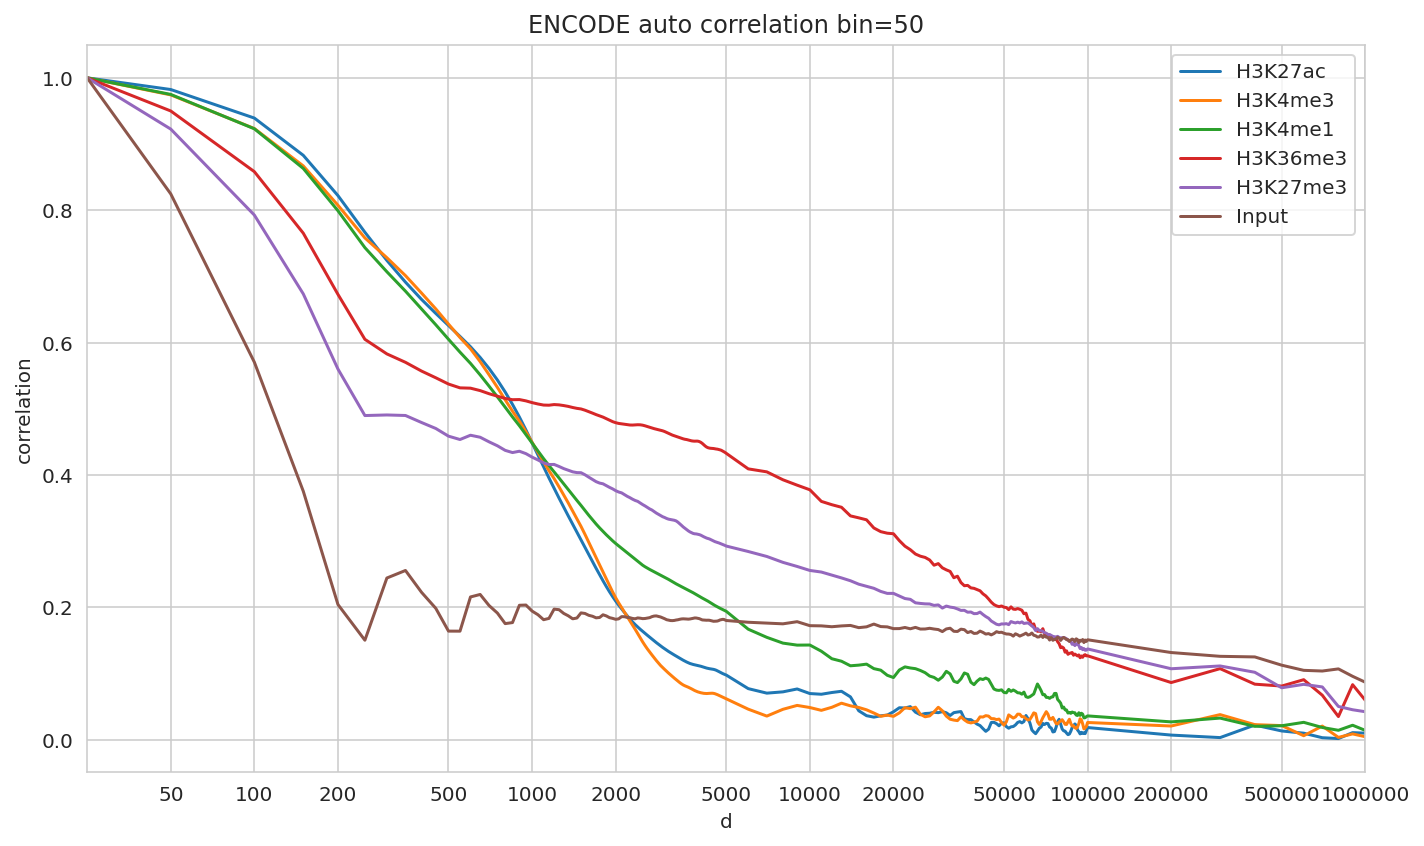

In [18]:
# plt.figure(figsize=(5, 3))
plt.figure(figsize=(10, 6))
ax = plt.axes()
# Show aggregated data, since we don't want error plots
t = df_correlations.copy()
t.loc[t['d'] == 0, 'd'] = BIN / 2  
t = t[['modification', 'd', 'correlation']].groupby(['modification', 'd']).mean().reset_index()
g_results = sns.lineplot(data=t, x="d", y="correlation", hue="modification",
                         hue_order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3', 'Input'])
# ticks = [10, 100, 1000, 10_000, 100_000, 1_000_000]
ticks = [1, 20, 50, 100, 200, 500, 1000, 2000, 5000,
         10_000, 20_000, 50_000, 100_000, 200_000, 500_000, 1_000_000]

g_results.set(xscale='log')
g_results.set(xticks=ticks)
g_results.set(xticklabels=ticks)
ax.title.set_text(f'ENCODE auto correlation bin={BIN}')
ax.set_xlim(BIN / 2, 1_000_000)
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH}/pics/signal_correlation.pdf', bbox_inches='tight', dpi=300)
plt.show()

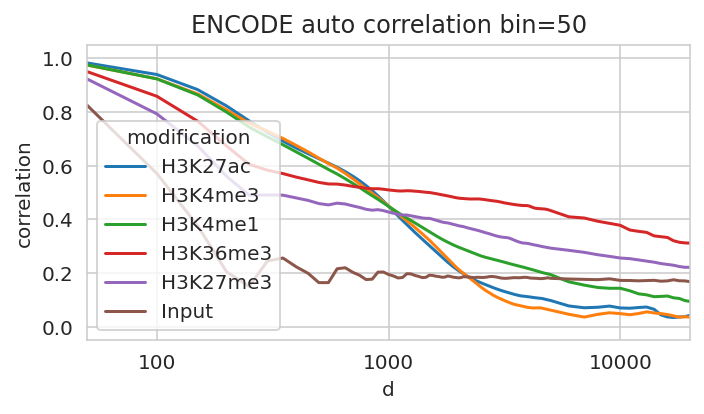

In [19]:
# plt.figure(figsize=(10, 6))
plt.figure(figsize=(5, 3))
g_results = sns.lineplot(data=t, x="d", y="correlation", hue="modification",
             hue_order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3', 'Input'])
ticks = [100, 1000, 10_000]
g_results.set(xscale='log')
g_results.set(xticks=ticks)
g_results.set(xticklabels=ticks)
ax = g_results.axes
ax.title.set_text(f'ENCODE auto correlation bin={BIN}')
ax.set_xlim(50, 20_000)
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH}/pics/signal_correlation_zoom.pdf', bbox_inches='tight', dpi=300)
plt.show()

# RoadmapEpigenomics autocorrelation

In [20]:
PATH = os.path.expanduser('~/data/2023_Immune')

IMMUNE_CELLS = ['BCell', 'TCell', 'Monocyte']
MODIFICATIONS = ['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3', 'Control']

In [21]:
df_correlations_roadmap_paper = compute_autocorrelations_paper(
    GSE26320_MODIFICATIONS, IMMUNE_CELLS, [''],
    {'chr22': CHROM_SIZES['chr22']}, BIN, DS, control='Control', bwpath=PATH + '/bwext'
)
df_correlations_roadmap_paper.sample(3)

  0%|          | 0/18 [00:00<?, ?it/s]

H3K4me3 BCell  BCell_H3K4me3_hg38_ENCFF213VRU_ext.bw BCell_Control_hg38_ENCFF198QJK_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me3 BCell  binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 90266750.0 control: 74987650.0
Mean signal 170.11401648998822 control 123.79674509519062
Estimating b between 0 and 1
I=32, b=0.32, correlation=0.0007088019944080644
Computing autocorrelations
H3K4me3 TCell  TCell_H3K4me3_hg38_ENCFF661HCG_ext.bw TCell_Control_hg38_ENCFF566HDE_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me3 TCell  binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 117656650.0 control: 97016250.0
Mean signal 214.73875080762028 control 151.55663206963564
Estimating b between 0 and 1
I=44, b=0.44, correlation=0.0005703566323898442
Computing autocorrelations
H3K4me3 Monocyte  Monocyte_H3K4me3_hg38_ENCFF642LZZ_ext.bw Monocyte_Control_hg38_ENCFF328STD_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me3 Monocyte  binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 82927500.0 control: 66649500.0
Mean signal 181.3471219324449 control 113.49212700996661
Estimating b between 0 and 1
I=28, b=0.28, correlation=0.000515963374510194
Computing autocorrelations
H3K4me1 BCell  BCell_H3K4me1_hg38_ENCFF584OXC_ext.bw BCell_Control_hg38_ENCFF198QJK_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me1 BCell  binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 167764900.0 control: 74987650.0
Mean signal 327.385752032441 control 123.79674509519062
Estimating b between 0 and 1
I=41, b=0.41000000000000003, correlation=0.0008810279188796932
Computing autocorrelations
H3K4me1 TCell  TCell_H3K4me1_hg38_ENCFF737JXT_ext.bw TCell_Control_hg38_ENCFF566HDE_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me1 TCell  binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 152536750.0 control: 97016250.0
Mean signal 312.16718716104765 control 151.55663206963564
Estimating b between 0 and 1
I=33, b=0.33, correlation=0.0013897386763384997
Computing autocorrelations
H3K4me1 Monocyte  Monocyte_H3K4me1_hg38_ENCFF396RZF_ext.bw Monocyte_Control_hg38_ENCFF328STD_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me1 Monocyte  binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 159009100.0 control: 66649500.0
Mean signal 395.89069062788656 control 113.49212700996661
Estimating b between 0 and 1
I=31, b=0.31, correlation=6.317281828217489e-05
Computing autocorrelations
H3K27ac BCell  BCell_H3K27ac_hg38_ENCFF404HKA_ext.bw BCell_Control_hg38_ENCFF198QJK_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27ac BCell  binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 85811150.0 control: 74987650.0
Mean signal 174.40120886200722 control 123.79674509519062
Estimating b between 0 and 1
I=45, b=0.45, correlation=0.0006848038979701274
Computing autocorrelations
H3K27ac TCell  TCell_H3K27ac_hg38_ENCFF530DQB_ext.bw TCell_Control_hg38_ENCFF566HDE_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27ac TCell  binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 117731050.0 control: 97016250.0
Mean signal 209.4280936752319 control 151.55663206963564
Estimating b between 0 and 1
I=52, b=0.52, correlation=8.6941408807115e-05
Computing autocorrelations
H3K36me3 BCell  BCell_H3K36me3_hg38_ENCFF207YSM_ext.bw BCell_Control_hg38_ENCFF198QJK_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K36me3 BCell  binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 108114850.0 control: 74987650.0
Mean signal 222.34050648009904 control 123.79674509519062
Estimating b between 0 and 1
I=17, b=0.17, correlation=0.0016383127128639097
Computing autocorrelations
H3K36me3 TCell  TCell_H3K36me3_hg38_ENCFF783YIM_ext.bw TCell_Control_hg38_ENCFF566HDE_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K36me3 TCell  binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 108111450.0 control: 97016250.0
Mean signal 226.71100448970262 control 151.55663206963564
Estimating b between 0 and 1
I=22, b=0.22, correlation=0.0010707198602545554
Computing autocorrelations
H3K36me3 Monocyte  Monocyte_H3K36me3_hg38_ENCFF164MUD_ext.bw Monocyte_Control_hg38_ENCFF328STD_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K36me3 Monocyte  binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 108694900.0 control: 66649500.0
Mean signal 281.6966345132147 control 113.49212700996661
Estimating b between 0 and 1
I=8, b=0.08, correlation=0.0010801648690596925
Computing autocorrelations
H3K27me3 BCell  BCell_H3K27me3_hg38_ENCFF118UGM_ext.bw BCell_Control_hg38_ENCFF198QJK_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27me3 BCell  binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 99025200.0 control: 74987650.0
Mean signal 176.09426292185182 control 123.79674509519062
Estimating b between 0 and 1
I=0, b=0.0, correlation=0.009214458682635842
Computing autocorrelations
H3K27me3 TCell  TCell_H3K27me3_hg38_ENCFF192QMJ_ext.bw TCell_Control_hg38_ENCFF566HDE_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27me3 TCell  binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 137564100.0 control: 97016250.0
Mean signal 240.5850049843474 control 151.55663206963564
Estimating b between 0 and 1
I=0, b=0.0, correlation=0.022489547672418786
Computing autocorrelations
H3K27me3 Monocyte  Monocyte_H3K27me3_gh38_ENCFF850DZD_ext.bw Monocyte_Control_hg38_ENCFF328STD_ext.bw


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27me3 Monocyte  binned 50bp coverage correlations on chr chr22 50818468
chr22 Coverage mln signal: 83958200.0 control: 66649500.0
Mean signal 165.89087244741702 control 113.49212700996661
Estimating b between 0 and 1
I=5, b=0.05, correlation=0.00044161565843544833
Computing autocorrelations


,modification,cell,replicate,file,chr,coverage mean,control mean,b,d,correlation,pvalue
20,H3K4me3,BCell,,BCell_H3K4me3_hg38_ENCFF213VRU_ext.bw,chr22,170.114016,123.796745,0.32,1000,0.257173,None
2425,H3K27me3,BCell,,BCell_H3K27me3_hg38_ENCFF118UGM_ext.bw,chr22,176.094263,123.796745,0.00,75000,0.061916,None
1067,H3K4me1,Monocyte,,Monocyte_H3K4me1_hg38_ENCFF396RZF_ext.bw,chr22,395.890691,113.492127,0.31,2100,0.344441,None


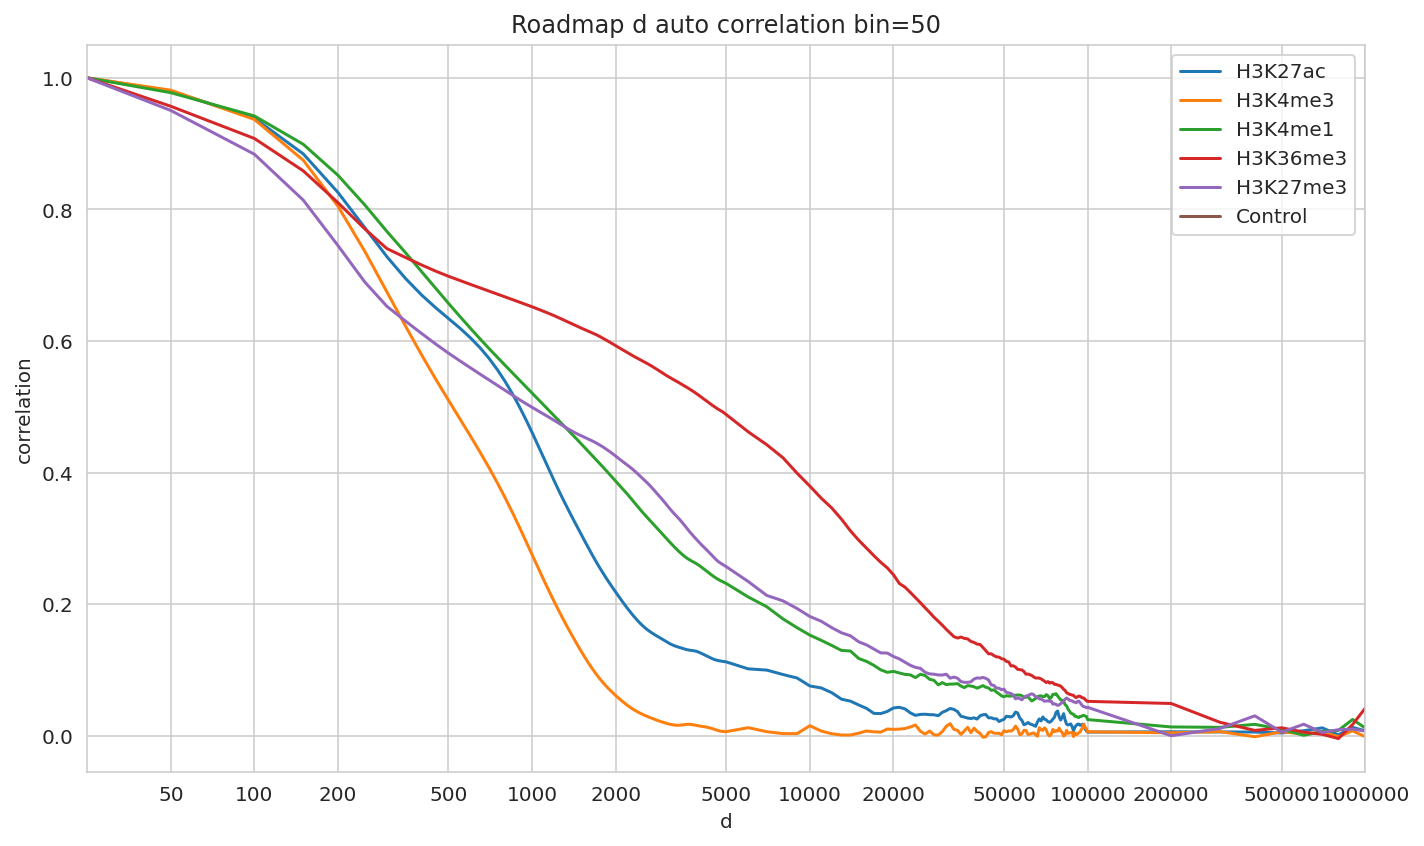

In [22]:
# plt.figure(figsize=(5, 3))
plt.figure(figsize=(10, 6))
ax = plt.axes()
# Show aggregated data, since we don't want error plots
t = df_correlations_roadmap_paper.copy()
t.loc[t['d'] == 0, 'd'] = BIN / 2
t = t[['modification', 'd', 'correlation']].groupby(['modification', 'd']).mean().reset_index()
g_results = sns.lineplot(data=t, x="d", y="correlation", hue="modification",
                         hue_order=MODIFICATIONS)
# ticks = [10, 100, 1000, 10_000, 100_000, 1_000_000]
ticks = [1, 20, 50, 100, 200, 500, 1000, 2000, 5000,
         10_000, 20_000, 50_000, 100_000, 200_000, 500_000, 1_000_000]

g_results.set(xscale='log')
g_results.set(xticks=ticks)
g_results.set(xticklabels=ticks)
ax.title.set_text(f'Roadmap d auto correlation bin={BIN}')
ax.set_xlim(BIN / 2, 1_000_000)
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/signal_correlation_paper.pdf', bbox_inches='tight', dpi=300)
plt.show()

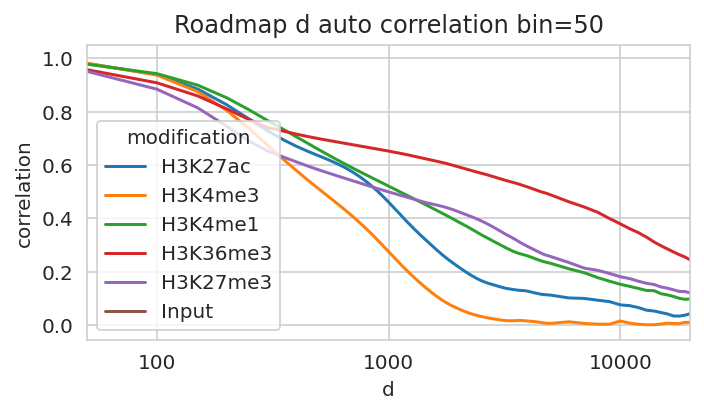

In [23]:
# plt.figure(figsize=(10, 6))
plt.figure(figsize=(5, 3))
g_results = sns.lineplot(data=t, x="d", y="correlation", hue="modification",
                         hue_order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3', 'Input'])
ticks = [100,  1000, 10_000]
g_results.set(xscale='log')
g_results.set(xticks=ticks)
g_results.set(xticklabels=ticks)
ax = g_results.axes
ax.title.set_text(f'Roadmap d auto correlation bin={BIN}')
ax.set_xlim(50, 20_000)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/signal_correlation_paper_zoom.pdf', bbox_inches='tight', dpi=300)
plt.show()

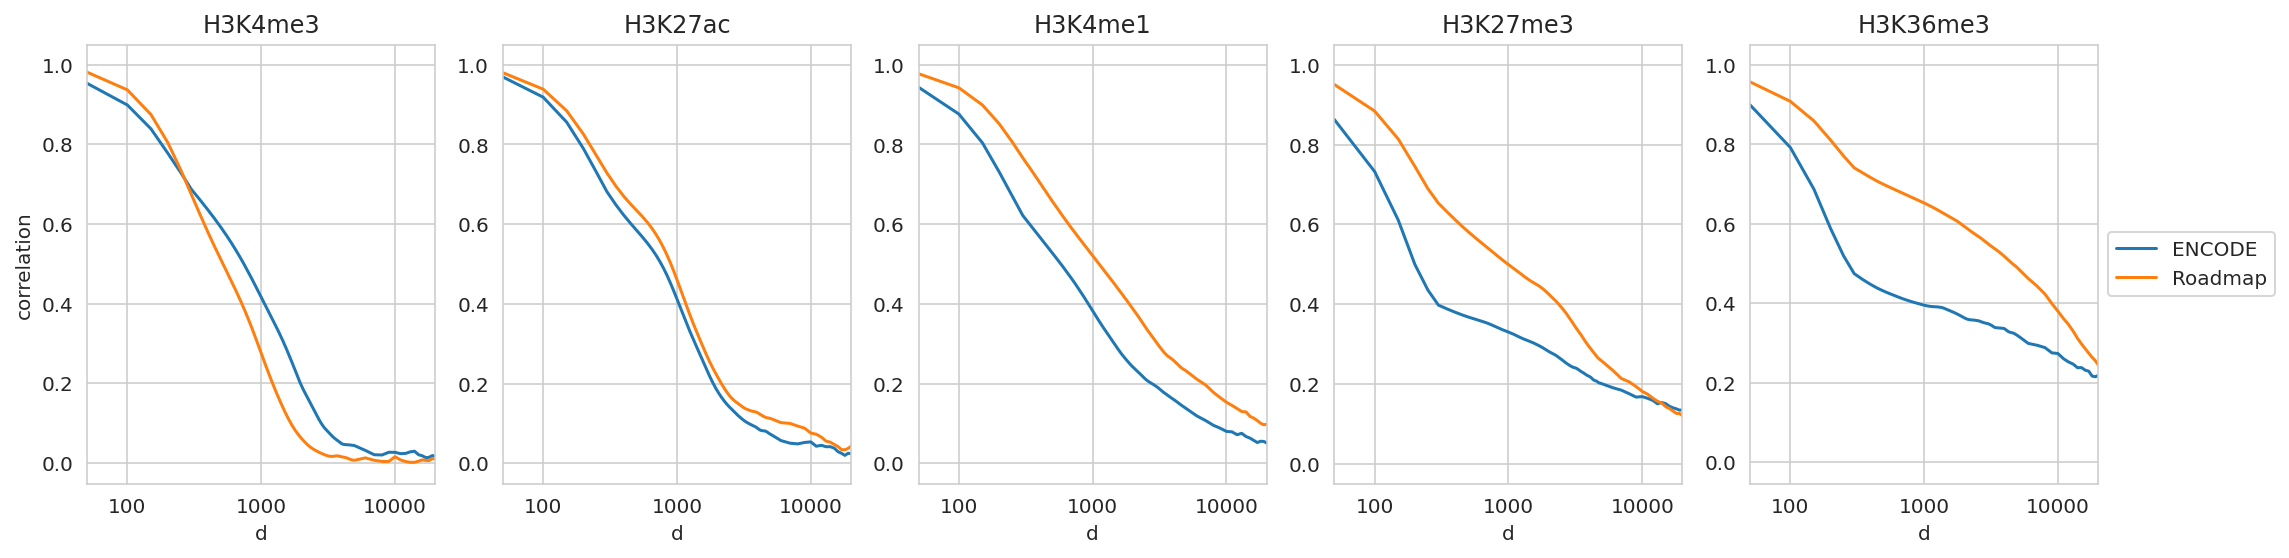

In [24]:
t1 = df_correlations_paper.copy()
t1 = t1[['modification', 'd', 'correlation']].groupby(['modification', 'd']).mean().reset_index()
t1['dataset'] = 'ENCODE'

t2 = df_correlations_roadmap_paper.copy()
t2 = t2[['modification', 'd', 'correlation']].groupby(['modification', 'd']).mean().reset_index()
t2['dataset'] = 'Roadmap'

t = pd.concat([t1, t2]).reset_index()

plt.figure(figsize=(16, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.lineplot(data=t[t['modification'] == m], x="d", y="correlation", hue='dataset', ax=ax)
    ticks = [100, 1000, 10_000]
    g_results.set(xscale='log')
    g_results.set(xticks=ticks)
    g_results.set(xticklabels=ticks)
    ax.title.set_text(f'{m}')
    ax.set_xlim(50, 20_000)
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)    
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.show()

In [25]:
chr_sizes = {'chr22': CHROM_SIZES['chr22']}
df_correlations_roadmap = compute_autocorrelations(MODIFICATIONS, IMMUNE_CELLS, [''],
                                                   {'chr22': CHROM_SIZES['chr22']},
                                                   BIN, DS, bwpath=PATH + '/bwext')
df_correlations_roadmap

  0%|          | 0/18 [00:00<?, ?it/s]

H3K27ac BCell  BCell_H3K27ac_hg38_ENCFF404HKA_ext.bw
Computing binned coverage correlations
Signal coverage mln 5245.932491


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27ac BCell binned 50bp coverage correlations on chr chr22 50818468
H3K27ac TCell  TCell_H3K27ac_hg38_ENCFF530DQB_ext.bw
Computing binned coverage correlations
Signal coverage mln 7576.004842


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27ac TCell binned 50bp coverage correlations on chr chr22 50818468
H3K4me3 BCell  BCell_H3K4me3_hg38_ENCFF213VRU_ext.bw
Computing binned coverage correlations
Signal coverage mln 6137.396786


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me3 BCell binned 50bp coverage correlations on chr chr22 50818468
H3K4me3 TCell  TCell_H3K4me3_hg38_ENCFF661HCG_ext.bw
Computing binned coverage correlations
Signal coverage mln 7157.812137


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me3 TCell binned 50bp coverage correlations on chr chr22 50818468
H3K4me3 Monocyte  Monocyte_H3K4me3_hg38_ENCFF642LZZ_ext.bw
Computing binned coverage correlations
Signal coverage mln 5127.22794


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me3 Monocyte binned 50bp coverage correlations on chr chr22 50818468
H3K4me1 BCell  BCell_H3K4me1_hg38_ENCFF584OXC_ext.bw
Computing binned coverage correlations
Signal coverage mln 7174.015561


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me1 BCell binned 50bp coverage correlations on chr chr22 50818468
H3K4me1 TCell  TCell_H3K4me1_hg38_ENCFF737JXT_ext.bw
Computing binned coverage correlations
Signal coverage mln 5649.149563


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me1 TCell binned 50bp coverage correlations on chr chr22 50818468
H3K4me1 Monocyte  Monocyte_H3K4me1_hg38_ENCFF396RZF_ext.bw
Computing binned coverage correlations
Signal coverage mln 7524.46709


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K4me1 Monocyte binned 50bp coverage correlations on chr chr22 50818468
H3K36me3 BCell  BCell_H3K36me3_hg38_ENCFF207YSM_ext.bw
Computing binned coverage correlations
Signal coverage mln 5626.813434


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K36me3 BCell binned 50bp coverage correlations on chr chr22 50818468
H3K36me3 TCell  TCell_H3K36me3_hg38_ENCFF783YIM_ext.bw
Computing binned coverage correlations
Signal coverage mln 5564.975092


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K36me3 TCell binned 50bp coverage correlations on chr chr22 50818468
H3K36me3 Monocyte  Monocyte_H3K36me3_hg38_ENCFF164MUD_ext.bw
Computing binned coverage correlations
Signal coverage mln 5009.471421


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K36me3 Monocyte binned 50bp coverage correlations on chr chr22 50818468
H3K27me3 BCell  BCell_H3K27me3_hg38_ENCFF118UGM_ext.bw
Computing binned coverage correlations
Signal coverage mln 6487.976392


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27me3 BCell binned 50bp coverage correlations on chr chr22 50818468
H3K27me3 TCell  TCell_H3K27me3_hg38_ENCFF192QMJ_ext.bw
Computing binned coverage correlations
Signal coverage mln 6369.47488


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27me3 TCell binned 50bp coverage correlations on chr chr22 50818468
H3K27me3 Monocyte  Monocyte_H3K27me3_gh38_ENCFF850DZD_ext.bw
Computing binned coverage correlations
Signal coverage mln 5544.737929


  0%|          | 0/1 [00:00<?, ?it/s]

Computing H3K27me3 Monocyte binned 50bp coverage correlations on chr chr22 50818468
Control BCell  BCell_Control_hg38_ENCFF198QJK_ext.bw
Computing binned coverage correlations
Signal coverage mln 7270.316


  0%|          | 0/1 [00:00<?, ?it/s]

Computing Control BCell binned 50bp coverage correlations on chr chr22 50818468
Control TCell  TCell_Control_hg38_ENCFF566HDE_ext.bw
Computing binned coverage correlations
Signal coverage mln 8797.474842


  0%|          | 0/1 [00:00<?, ?it/s]

Computing Control TCell binned 50bp coverage correlations on chr chr22 50818468
Control Monocyte  Monocyte_Control_hg38_ENCFF328STD_ext.bw
Computing binned coverage correlations
Signal coverage mln 4996.828981


  0%|          | 0/1 [00:00<?, ?it/s]

Computing Control Monocyte binned 50bp coverage correlations on chr chr22 50818468


,modification,cell,replicate,file,chr,d,correlation,pvalue
0,H3K27ac,BCell,,BCell_H3K27ac_hg38_ENCFF404HKA_ext.bw,chr22,0,1.000000,0.000000e+00
1,H3K27ac,BCell,,BCell_H3K27ac_hg38_ENCFF404HKA_ext.bw,chr22,50,0.984351,0.000000e+00
2,H3K27ac,BCell,,BCell_H3K27ac_hg38_ENCFF404HKA_ext.bw,chr22,100,0.943609,0.000000e+00
3,H3K27ac,BCell,,BCell_H3K27ac_hg38_ENCFF404HKA_ext.bw,chr22,150,0.887915,0.000000e+00
4,H3K27ac,BCell,,BCell_H3K27ac_hg38_ENCFF404HKA_ext.bw,chr22,200,0.826766,0.000000e+00
...,...,...,...,...,...,...,...,...
3480,Control,Monocyte,,Monocyte_Control_hg38_ENCFF328STD_ext.bw,chr22,600000,0.009255,1.317773e-12
3481,Control,Monocyte,,Monocyte_Control_hg38_ENCFF328STD_ext.bw,chr22,700000,0.006075,3.230814e-06
3482,Control,Monocyte,,Monocyte_Control_hg38_ENCFF328STD_ext.bw,chr22,800000,0.001963,1.324879e-01
3483,Control,Monocyte,,Monocyte_Control_hg38_ENCFF328STD_ext.bw,chr22,900000,0.003029,2.029532e-02


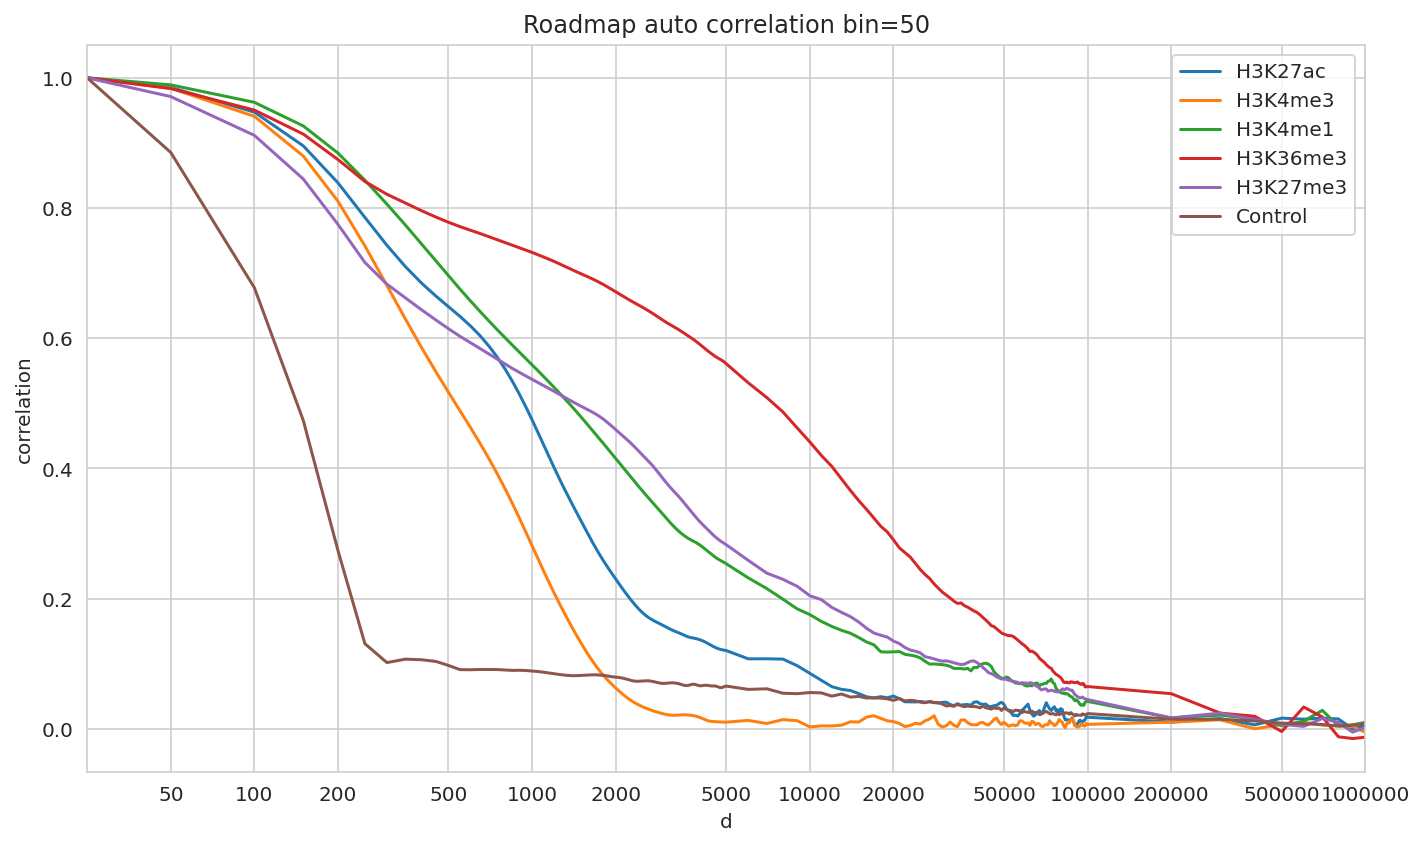

In [26]:
# plt.figure(figsize=(5, 3))
plt.figure(figsize=(10, 6))
ax = plt.axes()
# Show aggregated data, since we don't want error plots
t = df_correlations_roadmap.copy()
t.loc[t['d'] == 0, 'd'] = BIN / 2
t = t[['modification', 'd', 'correlation']].groupby(['modification', 'd']).mean().reset_index()
g_results = sns.lineplot(data=t, x="d", y="correlation", hue="modification",
                         hue_order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3', 'Control'])
# ticks = [10, 100, 1000, 10_000, 100_000, 1_000_000]
ticks = [1, 20, 50, 100, 200, 500, 1000, 2000, 5000,
         10_000, 20_000, 50_000, 100_000, 200_000, 500_000, 1_000_000]

g_results.set(xscale='log')
g_results.set(xticks=ticks)
g_results.set(xticklabels=ticks)
ax.title.set_text(f'Roadmap auto correlation bin={BIN}')
ax.set_xlim(BIN / 2, 1_000_000)
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'{PATH}/pics/signal_correlation.pdf', bbox_inches='tight', dpi=300)
plt.show()

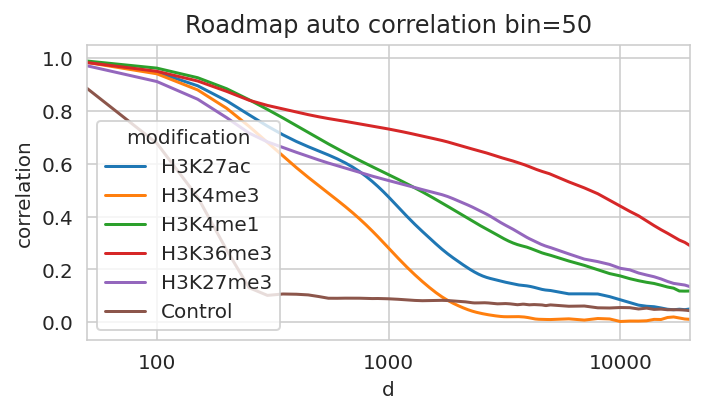

In [27]:
# plt.figure(figsize=(10, 6))
plt.figure(figsize=(5, 3))
ax = plt.axes()
g_results = sns.lineplot(data=t, x="d", y="correlation", hue="modification",
                         hue_order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3', 'Control'])
ticks = [100, 1000, 10_000]
g_results.set(xscale='log')
g_results.set(xticks=ticks)
g_results.set(xticklabels=ticks)
ax.title.set_text(f'Roadmap auto correlation bin={BIN}')
ax.set_xlim(50, 20_000)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/signal_correlation_zoom.pdf', bbox_inches='tight', dpi=300)
plt.show()

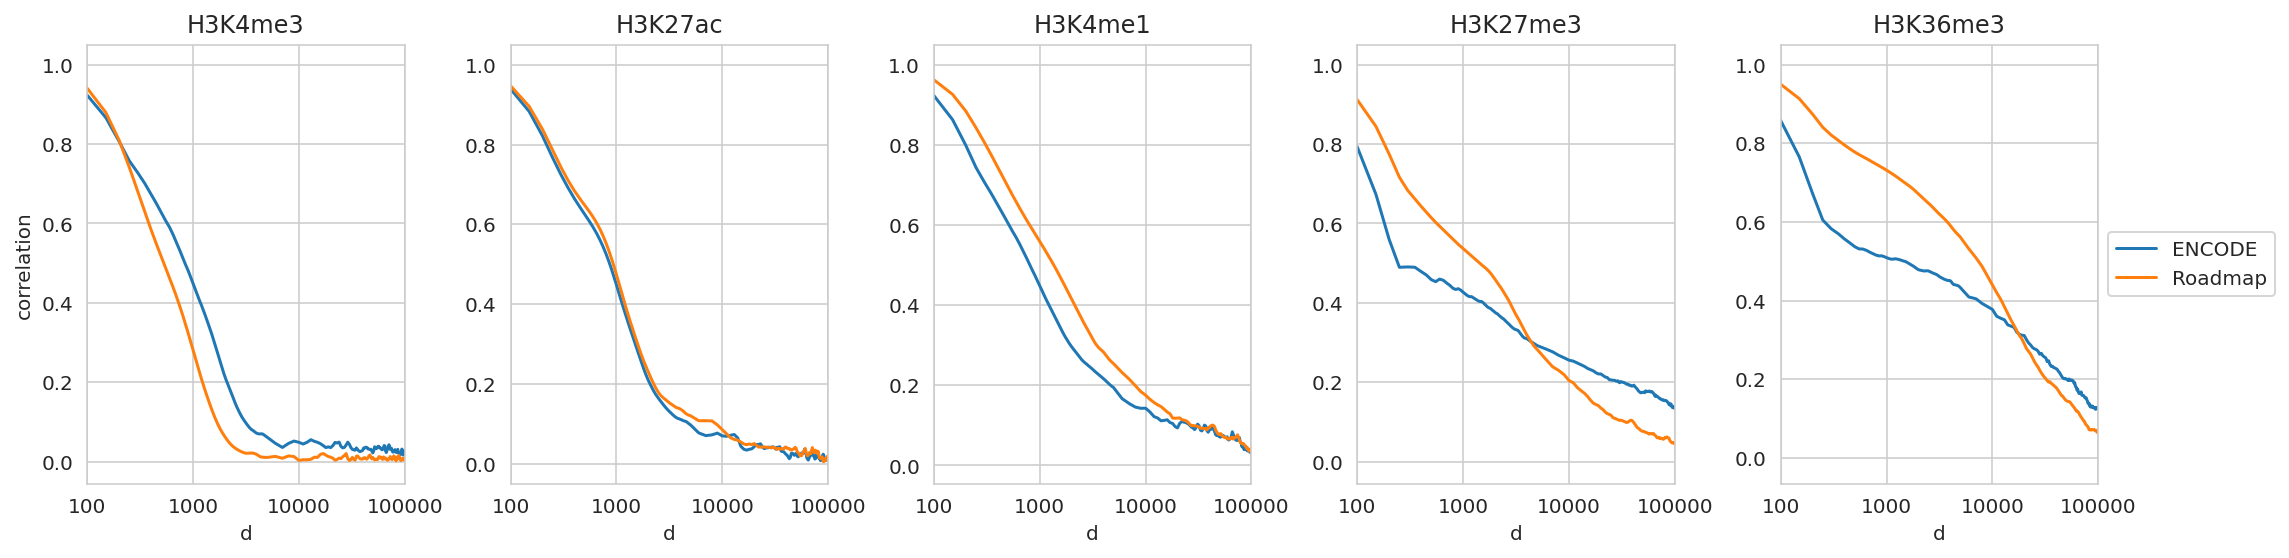

In [28]:
t1 = df_correlations.copy()
t1 = t1[['modification', 'd', 'correlation']].groupby(['modification', 'd']).mean().reset_index()
t1['dataset'] = 'ENCODE'

t2 = df_correlations_roadmap.copy()
t2 = t2[['modification', 'd', 'correlation']].groupby(['modification', 'd']).mean().reset_index()
t2['dataset'] = 'Roadmap'

t = pd.concat([t1, t2]).reset_index()

plt.figure(figsize=(16, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    ax = axs[i]
    g_results = sns.lineplot(data=t[t['modification'] == m], x="d", y="correlation", hue='dataset', ax=ax)
    ticks = [100, 1000, 10_000, 100_000]
    g_results.set(xscale='log')
    g_results.set(xticks=ticks)
    g_results.set(xticklabels=ticks)
    ax.title.set_text(f'{m}')
    ax.set_xlim(100, 100_000)
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)    
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.show()

## Peaks profile

In [29]:
IMMUNE_SPAN_PATH = os.path.join(PATH, 'span')
IMMUNE_BW_PATH = os.path.join(PATH, 'bwext')

df_immune_cov = signal_peaks_profile(MODIFICATIONS, IMMUNE_CELLS, [''], IMMUNE_SPAN_PATH, IMMUNE_BW_PATH, 'Control')
df_immune_cov

  0%|          | 0/18 [00:00<?, ?it/s]

H3K27ac BCell  BCell_H3K27ac_hg38_ENCFF404HKA_100_0.05_3.peak BCell_H3K27ac_hg38_ENCFF404HKA_ext.bw
H3K27ac TCell  TCell_H3K27ac_hg38_ENCFF530DQB_100_0.05_3.peak TCell_H3K27ac_hg38_ENCFF530DQB_ext.bw
H3K4me3 BCell  BCell_H3K4me3_hg38_ENCFF213VRU_100_0.05_3.peak BCell_H3K4me3_hg38_ENCFF213VRU_ext.bw
H3K4me3 TCell  TCell_H3K4me3_hg38_ENCFF661HCG_100_0.05_3.peak TCell_H3K4me3_hg38_ENCFF661HCG_ext.bw
H3K4me3 Monocyte  Monocyte_H3K4me3_hg38_ENCFF642LZZ_100_0.05_3.peak Monocyte_H3K4me3_hg38_ENCFF642LZZ_ext.bw
H3K4me1 BCell  BCell_H3K4me1_hg38_ENCFF584OXC_100_0.05_3.peak BCell_H3K4me1_hg38_ENCFF584OXC_ext.bw
H3K4me1 TCell  TCell_H3K4me1_hg38_ENCFF737JXT_100_0.05_3.peak TCell_H3K4me1_hg38_ENCFF737JXT_ext.bw
H3K4me1 Monocyte  Monocyte_H3K4me1_hg38_ENCFF396RZF_100_0.05_3.peak Monocyte_H3K4me1_hg38_ENCFF396RZF_ext.bw
H3K36me3 BCell  BCell_H3K36me3_hg38_ENCFF207YSM_100_0.05_3.peak BCell_H3K36me3_hg38_ENCFF207YSM_ext.bw
H3K36me3 TCell  TCell_H3K36me3_hg38_ENCFF783YIM_100_0.05_3.peak TCell_H3K36me3_

,modification,cell,replicate,peak,x,coverage
0,H3K27ac,BCell,,0,-5000.0,0.288700
1,H3K27ac,BCell,,0,-4950.0,0.256622
2,H3K27ac,BCell,,0,-4900.0,0.219198
3,H3K27ac,BCell,,0,-4850.0,0.224544
4,H3K27ac,BCell,,0,-4800.0,0.171081
...,...,...,...,...,...,...
559995,Control,Monocyte,,99,4750.0,0.056836
559996,Control,Monocyte,,99,4800.0,0.056836
559997,Control,Monocyte,,99,4850.0,0.048310
559998,Control,Monocyte,,99,4900.0,0.036943


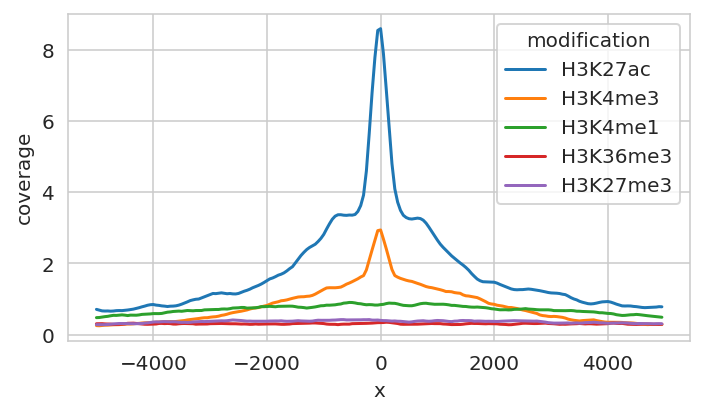

In [30]:
plt.figure(figsize=(5, 3))
# Show aggregated data, since we don't want error plots
t = df_gse26320_cov[['modification', 'x', 'coverage']].groupby(['modification', 'x']).mean().reset_index()
sns.lineplot(data=t, x="x", y="coverage", hue="modification", err_style=None,
             hue_order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'])
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks_profile.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Peaks intensities

In [31]:
data = []
for mod, cell, rep in tqdm(list(product(MODIFICATIONS, IMMUNE_CELLS, ['']))):
    peaksfile = next((f for f in os.listdir(IMMUNE_SPAN_PATH) if mod in f and cell in f and rep in f), None)
    bwfile = next((f for f in os.listdir(IMMUNE_BW_PATH) if '.bw' in f and mod in f and cell in f and rep in f), None)
    bwcfile = next((f for f in os.listdir(IMMUNE_BW_PATH) if '.bw' in f and 'Control' in f and cell in f and rep in f), None)
    if peaksfile is None or bwfile is None or bwcfile is None:
        continue
    print(mod, cell, rep, peaksfile, bwfile, bwcfile)

    # Load peaks file and sort by score
    peaksfile_df = pd.read_csv(os.path.join(IMMUNE_SPAN_PATH, peaksfile), sep='\t',
                               names=['chr', 'start', 'end', '4', '5', '6', '7', '8', 'score'])
    with pyBigWig.open(os.path.join(IMMUNE_BW_PATH, bwfile)) as bw:
        with pyBigWig.open(os.path.join(IMMUNE_BW_PATH, bwcfile)) as bwc:
            # Resort top scored peaks by density and start with the most dense ones
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            total_coveragec = sum(bwc.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr) / 1e6
            for _, (chr, start, end) in peaksfile_df[['chr', 'start', 'end']].iterrows():
                if '_' in chr:
                    continue
                peak_coverage = bw.stats(chr, start, end, exact=True, type='sum')[0]
                peak_coveragec = bwc.stats(chr, start, end, exact=True, type='sum')[0]
                data.append((mod, cell, rep, total_coverage, total_coveragec,
                             f'{chr}:{start}-{end}', end - start, peak_coverage, peak_coveragec))

immune_peak_coverages_df = pd.DataFrame(
    columns=['modification', 'cell', 'replicate', 'total_signal_coverage', 'total_control_coverage',
             'peak', 'length', 'signal_coverage', 'control_coverage'],
    data=data
)
del data
immune_peak_coverages_df

  0%|          | 0/18 [00:00<?, ?it/s]

H3K27ac BCell  BCell_H3K27ac_hg38_ENCFF404HKA_100_0.05_3.peak BCell_H3K27ac_hg38_ENCFF404HKA_ext.bw BCell_Control_hg38_ENCFF198QJK_ext.bw
H3K27ac TCell  TCell_H3K27ac_hg38_ENCFF530DQB_100_0.05_3.peak TCell_H3K27ac_hg38_ENCFF530DQB_ext.bw TCell_Control_hg38_ENCFF566HDE_ext.bw
H3K4me3 BCell  BCell_H3K4me3_hg38_ENCFF213VRU_100_0.05_3.peak BCell_H3K4me3_hg38_ENCFF213VRU_ext.bw BCell_Control_hg38_ENCFF198QJK_ext.bw
H3K4me3 TCell  TCell_H3K4me3_hg38_ENCFF661HCG_100_0.05_3.peak TCell_H3K4me3_hg38_ENCFF661HCG_ext.bw TCell_Control_hg38_ENCFF566HDE_ext.bw
H3K4me3 Monocyte  Monocyte_H3K4me3_hg38_ENCFF642LZZ_100_0.05_3.peak Monocyte_H3K4me3_hg38_ENCFF642LZZ_ext.bw Monocyte_Control_hg38_ENCFF328STD_ext.bw
H3K4me1 BCell  BCell_H3K4me1_hg38_ENCFF584OXC_100_0.05_3.peak BCell_H3K4me1_hg38_ENCFF584OXC_ext.bw BCell_Control_hg38_ENCFF198QJK_ext.bw
H3K4me1 TCell  TCell_H3K4me1_hg38_ENCFF737JXT_100_0.05_3.peak TCell_H3K4me1_hg38_ENCFF737JXT_ext.bw TCell_Control_hg38_ENCFF566HDE_ext.bw
H3K4me1 Monocyte  Mono

,modification,cell,replicate,total_signal_coverage,total_control_coverage,peak,length,signal_coverage,control_coverage
0,H3K27ac,BCell,,5240.431808,7258.653697,chr1:633925-633977,52,757.0,1512.0
1,H3K27ac,BCell,,5240.431808,7258.653697,chr1:778312-779289,977,23509.0,1500.0
2,H3K27ac,BCell,,5240.431808,7258.653697,chr1:827005-827551,546,22253.0,657.0
3,H3K27ac,BCell,,5240.431808,7258.653697,chr1:865236-866565,1329,52352.0,3552.0
4,H3K27ac,BCell,,5240.431808,7258.653697,chr1:959005-959200,195,2345.0,580.0
...,...,...,...,...,...,...,...,...,...
927438,H3K27me3,Monocyte,,5538.728309,4987.117496,chrY:12421213-12422171,958,6651.0,1024.0
927439,H3K27me3,Monocyte,,5538.728309,4987.117496,chrY:14521611-14527100,5489,86284.0,4900.0
927440,H3K27me3,Monocyte,,5538.728309,4987.117496,chrY:19502168-19502600,432,4274.0,864.0
927441,H3K27me3,Monocyte,,5538.728309,4987.117496,chrY:19541142-19542800,1658,10064.0,2516.0


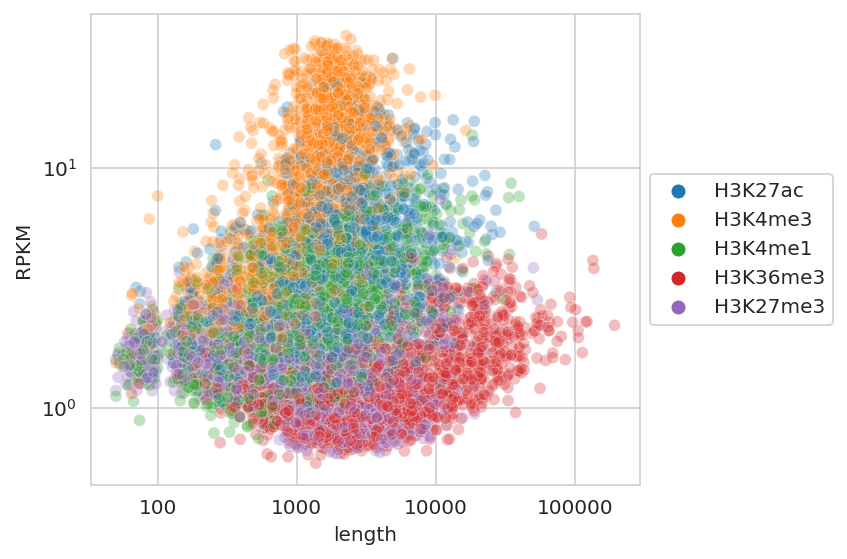

In [32]:
plt.figure(figsize=(6, 4))
t = pd.concat([immune_peak_coverages_df[immune_peak_coverages_df['modification'] == m].sample(2_000)
               for m in immune_peak_coverages_df['modification'].unique()]).reset_index(drop=True).sample(frac=1).reset_index(drop=True)
t['RPKM'] = t['signal_coverage'] / t['length'] * 1e3
t['RPKM'] /= t['total_signal_coverage']
t['RPKM'].clip(lower=0.2, inplace=True)
t['length'].clip(upper=3e5, inplace=True)
ticks = [100, 1000, 10_000, 100_000]
g_results = sns.scatterplot(data=t, x='length', y='RPKM', hue='modification', alpha=0.3,
                            hue_order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'])
# g_results = sns.kdeplot(data=t, x='length', y='RPKM', hue='modification', alpha=0.3,
#                             hue_order=['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3'], fill='true')
g_results.set(xscale='log')
g_results.set(xticks=ticks)
g_results.set(xticklabels=ticks)
g_results.set(yscale='log')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/peaks_length_vs_rpkm.pdf', bbox_inches='tight', dpi=300)
plt.show()

# ULI ChIPseq signal autocorrelation

In [33]:
ABF_PATH = os.path.expanduser('~/data/2018_chipseq_y20o20')
ABF_BW_PATH = os.path.join(ABF_PATH, 'bwext')
ABF_MODIFICATIONS = ['k27ac', 'k4me3', 'k4me1', 'k36me3', 'k27me3']

CHROM_SIZES_HG19 = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(ABF_PATH, 'hg19.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows()
}
! mkdir {ABF_PATH}/pics

mkdir: cannot create directory ‘/home/jetbrains/data/2018_chipseq_y20o20/pics’: File exists


In [34]:
df_correlations_abf = compute_autocorrelations(ABF_MODIFICATIONS, ['OD11', 'OD12', 'OD13'], [''],
                                               {'chr22': CHROM_SIZES_HG19['chr22']},
                                               BIN, DS, bwpath=ABF_BW_PATH)
df_correlations_abf

  0%|          | 0/15 [00:00<?, ?it/s]

k27ac OD11  OD11_k27ac_hg19_ext.bw
Computing binned coverage correlations
Signal coverage mln 4435.154981


  0%|          | 0/1 [00:00<?, ?it/s]

Computing k27ac OD11 binned 50bp coverage correlations on chr chr22 51304566
k27ac OD12  OD12_k27ac_hg19_ext.bw
Computing binned coverage correlations
Signal coverage mln 4117.64875


  0%|          | 0/1 [00:00<?, ?it/s]

Computing k27ac OD12 binned 50bp coverage correlations on chr chr22 51304566
k27ac OD13  OD13_k27ac_hg19_ext.bw
Computing binned coverage correlations
Signal coverage mln 5146.160021


  0%|          | 0/1 [00:00<?, ?it/s]

Computing k27ac OD13 binned 50bp coverage correlations on chr chr22 51304566
k4me3 OD11  OD11_k4me3_hg19_ext.bw
Computing binned coverage correlations
Signal coverage mln 7227.623042


  0%|          | 0/1 [00:00<?, ?it/s]

Computing k4me3 OD11 binned 50bp coverage correlations on chr chr22 51304566
k4me3 OD12  OD12_k4me3_hg19_ext.bw
Computing binned coverage correlations
Signal coverage mln 6436.246902


  0%|          | 0/1 [00:00<?, ?it/s]

Computing k4me3 OD12 binned 50bp coverage correlations on chr chr22 51304566
k4me3 OD13  OD13_k4me3_hg19_ext.bw
Computing binned coverage correlations
Signal coverage mln 7049.070702


  0%|          | 0/1 [00:00<?, ?it/s]

Computing k4me3 OD13 binned 50bp coverage correlations on chr chr22 51304566
k4me1 OD11  OD11_k4me1_hg19_ext.bw
Computing binned coverage correlations
Signal coverage mln 11334.210492


  0%|          | 0/1 [00:00<?, ?it/s]

Computing k4me1 OD11 binned 50bp coverage correlations on chr chr22 51304566
k4me1 OD12  OD12_k4me1_hg19_ext.bw
Computing binned coverage correlations
Signal coverage mln 9394.55165


  0%|          | 0/1 [00:00<?, ?it/s]

Computing k4me1 OD12 binned 50bp coverage correlations on chr chr22 51304566
k4me1 OD13  OD13_k4me1_hg19_ext.bw
Computing binned coverage correlations
Signal coverage mln 11670.186623


  0%|          | 0/1 [00:00<?, ?it/s]

Computing k4me1 OD13 binned 50bp coverage correlations on chr chr22 51304566
k36me3 OD11  OD11_k36me3_hg19_ext.bw
Computing binned coverage correlations
Signal coverage mln 6598.70505


  0%|          | 0/1 [00:00<?, ?it/s]

Computing k36me3 OD11 binned 50bp coverage correlations on chr chr22 51304566
k36me3 OD12  OD12_k36me3_hg19_ext.bw
Computing binned coverage correlations
Signal coverage mln 8657.183871


  0%|          | 0/1 [00:00<?, ?it/s]

Computing k36me3 OD12 binned 50bp coverage correlations on chr chr22 51304566
k36me3 OD13  OD13_k36me3_hg19_ext.bw
Computing binned coverage correlations
Signal coverage mln 9663.049484


  0%|          | 0/1 [00:00<?, ?it/s]

Computing k36me3 OD13 binned 50bp coverage correlations on chr chr22 51304566
k27me3 OD11  OD11_k27me3_hg19_ext.bw
Computing binned coverage correlations
Signal coverage mln 9325.223263


  0%|          | 0/1 [00:00<?, ?it/s]

Computing k27me3 OD11 binned 50bp coverage correlations on chr chr22 51304566
k27me3 OD12  OD12_k27me3_hg19_ext.bw
Computing binned coverage correlations
Signal coverage mln 8608.243905


  0%|          | 0/1 [00:00<?, ?it/s]

Computing k27me3 OD12 binned 50bp coverage correlations on chr chr22 51304566
k27me3 OD13  OD13_k27me3_hg19_ext.bw
Computing binned coverage correlations
Signal coverage mln 6582.335255


  0%|          | 0/1 [00:00<?, ?it/s]

Computing k27me3 OD13 binned 50bp coverage correlations on chr chr22 51304566


,modification,cell,replicate,file,chr,d,correlation,pvalue
0,k27ac,OD11,,OD11_k27ac_hg19_ext.bw,chr22,0,1.000000,0.000000e+00
1,k27ac,OD11,,OD11_k27ac_hg19_ext.bw,chr22,50,0.971771,0.000000e+00
2,k27ac,OD11,,OD11_k27ac_hg19_ext.bw,chr22,100,0.909663,0.000000e+00
3,k27ac,OD11,,OD11_k27ac_hg19_ext.bw,chr22,150,0.837508,0.000000e+00
4,k27ac,OD11,,OD11_k27ac_hg19_ext.bw,chr22,200,0.765139,0.000000e+00
...,...,...,...,...,...,...,...,...
3070,k27me3,OD13,,OD13_k27me3_hg19_ext.bw,chr22,600000,0.018412,3.944099e-43
3071,k27me3,OD13,,OD13_k27me3_hg19_ext.bw,chr22,700000,0.005178,1.082077e-04
3072,k27me3,OD13,,OD13_k27me3_hg19_ext.bw,chr22,800000,-0.003780,4.708597e-03
3073,k27me3,OD13,,OD13_k27me3_hg19_ext.bw,chr22,900000,-0.006490,1.218907e-06


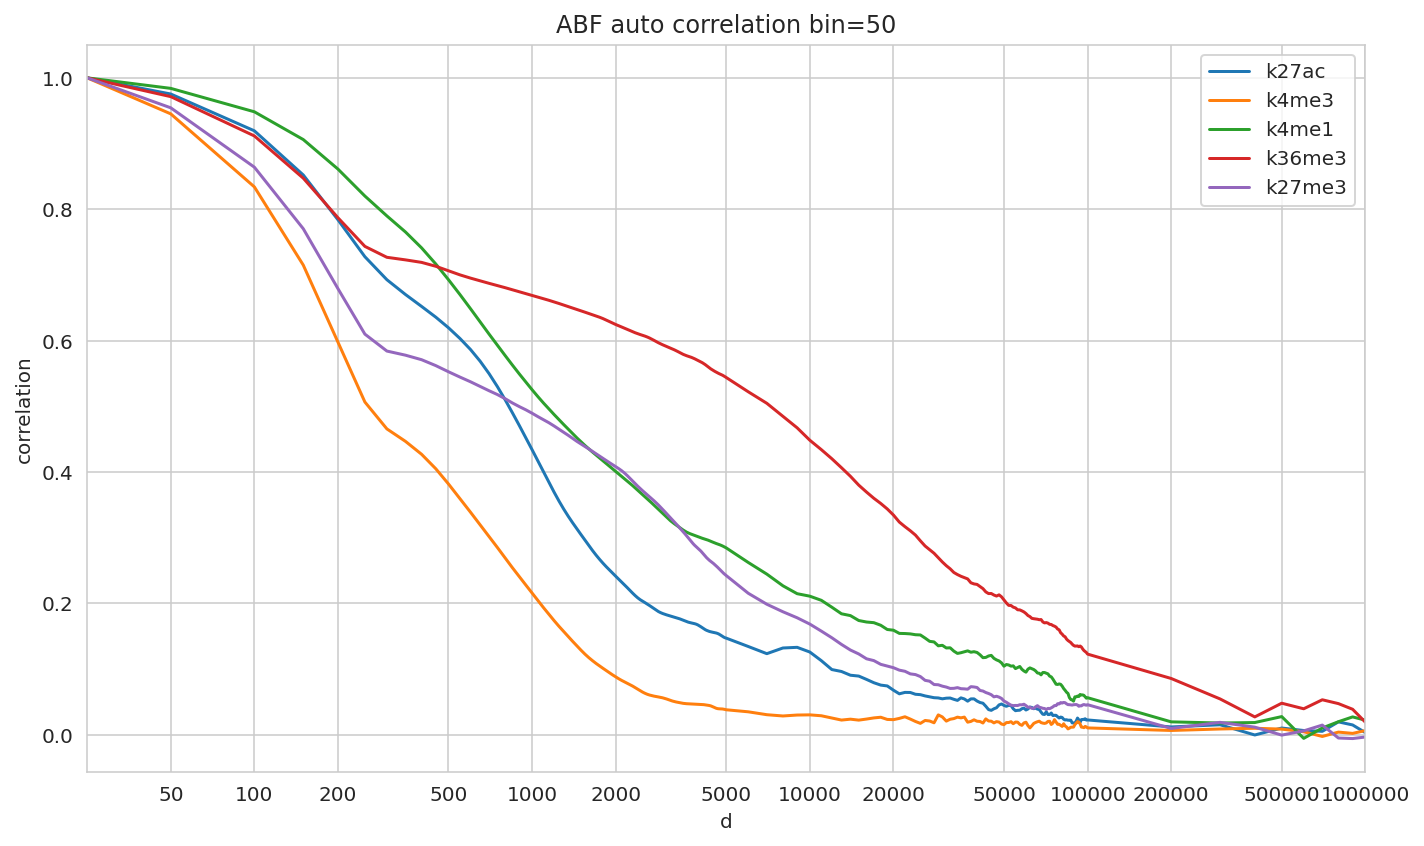

In [35]:
# plt.figure(figsize=(5, 3))
plt.figure(figsize=(10, 6))
ax = plt.axes()
# Show aggregated data, since we don't want error plots
t = df_correlations_abf.copy()
t.loc[t['d'] == 0, 'd'] = BIN / 2
t = t[['modification', 'd', 'correlation']].groupby(['modification', 'd']).mean().reset_index()
g_results = sns.lineplot(data=t, x="d", y="correlation", hue="modification",
                         hue_order=ABF_MODIFICATIONS)
# ticks = [10, 100, 1000, 10_000, 100_000, 1_000_000]
ticks = [1, 20, 50, 100, 200, 500, 1000, 2000, 5000,
         10_000, 20_000, 50_000, 100_000, 200_000, 500_000, 1_000_000]

g_results.set(xscale='log')
g_results.set(xticks=ticks)
g_results.set(xticklabels=ticks)
ax.title.set_text(f'ABF auto correlation bin={BIN}')
ax.set_xlim(BIN / 2, 1_000_000)
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'{ABF_PATH}/pics/signal_correlation.pdf', bbox_inches='tight', dpi=300)
plt.show()

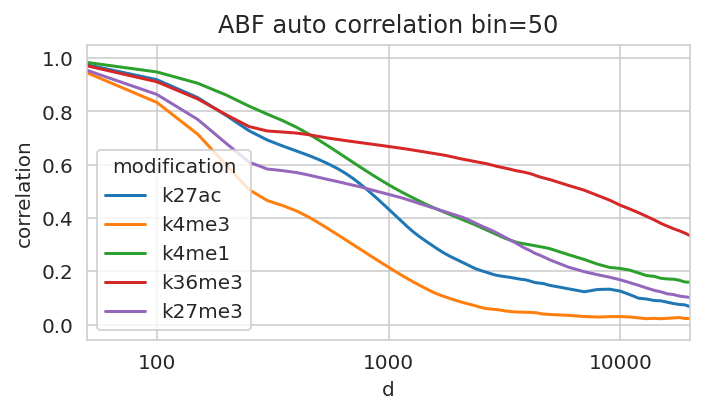

In [36]:
plt.figure(figsize=(5, 3))
# plt.figure(figsize=(10, 6))
ax = plt.axes()
g_results = sns.lineplot(data=t, x="d", y="correlation", hue="modification",
                         hue_order=ABF_MODIFICATIONS)
ticks = [100, 1000, 10_000]
g_results.set(xscale='log')
g_results.set(xticks=ticks)
g_results.set(xticklabels=ticks)
ax.title.set_text(f'ABF auto correlation bin={BIN}')
ax.set_xlim(50, 20_000)
plt.tight_layout()
plt.savefig(f'{ABF_PATH}/pics/signal_correlation_zoom.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Summary

In [37]:
# t1 = df_correlations_paper.copy()
# t1['dataset'] = 'ENCODE d'
# 
# t2 = df_correlations_roadmap_paper.copy()
# t2['dataset'] = 'Roadmap d'
# 
t3 = df_correlations.copy()
t3['dataset'] = 'ENCODE'

t4 = df_correlations_roadmap.copy()
t4['dataset'] = 'Roadmap'

t5 = df_correlations_abf.copy()
for m1, m2 in zip(['k27ac', 'k4me3', 'k4me1', 'k36me3', 'k27me3'],
                  ['H3K27ac', 'H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K27me3']):
    t5.loc[t5['modification'] == m1, 'modification'] = m2
t5['dataset'] = 'ABF'

# summary = pd.concat([t1, t2, t3, t4, t5]).reset_index()
summary = pd.concat([t3, t4, t5]).reset_index()
summary.loc[summary['modification'] == 'Input', 'modification'] = 'Control'
summary

,index,modification,cell,replicate,file,chr,d,correlation,pvalue,dataset
0,0,H3K27ac,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_ext.bw,chr22,0,1.000000,0.000000e+00,ENCODE
1,1,H3K27ac,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_ext.bw,chr22,50,0.983175,0.000000e+00,ENCODE
2,2,H3K27ac,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_ext.bw,chr22,100,0.943875,0.000000e+00,ENCODE
3,3,H3K27ac,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_ext.bw,chr22,150,0.893953,0.000000e+00,ENCODE
4,4,H3K27ac,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_ext.bw,chr22,200,0.839633,0.000000e+00,ENCODE
...,...,...,...,...,...,...,...,...,...,...
10040,3070,H3K27me3,OD13,,OD13_k27me3_hg19_ext.bw,chr22,600000,0.018412,3.944099e-43,ABF
10041,3071,H3K27me3,OD13,,OD13_k27me3_hg19_ext.bw,chr22,700000,0.005178,1.082077e-04,ABF
10042,3072,H3K27me3,OD13,,OD13_k27me3_hg19_ext.bw,chr22,800000,-0.003780,4.708597e-03,ABF
10043,3073,H3K27me3,OD13,,OD13_k27me3_hg19_ext.bw,chr22,900000,-0.006490,1.218907e-06,ABF


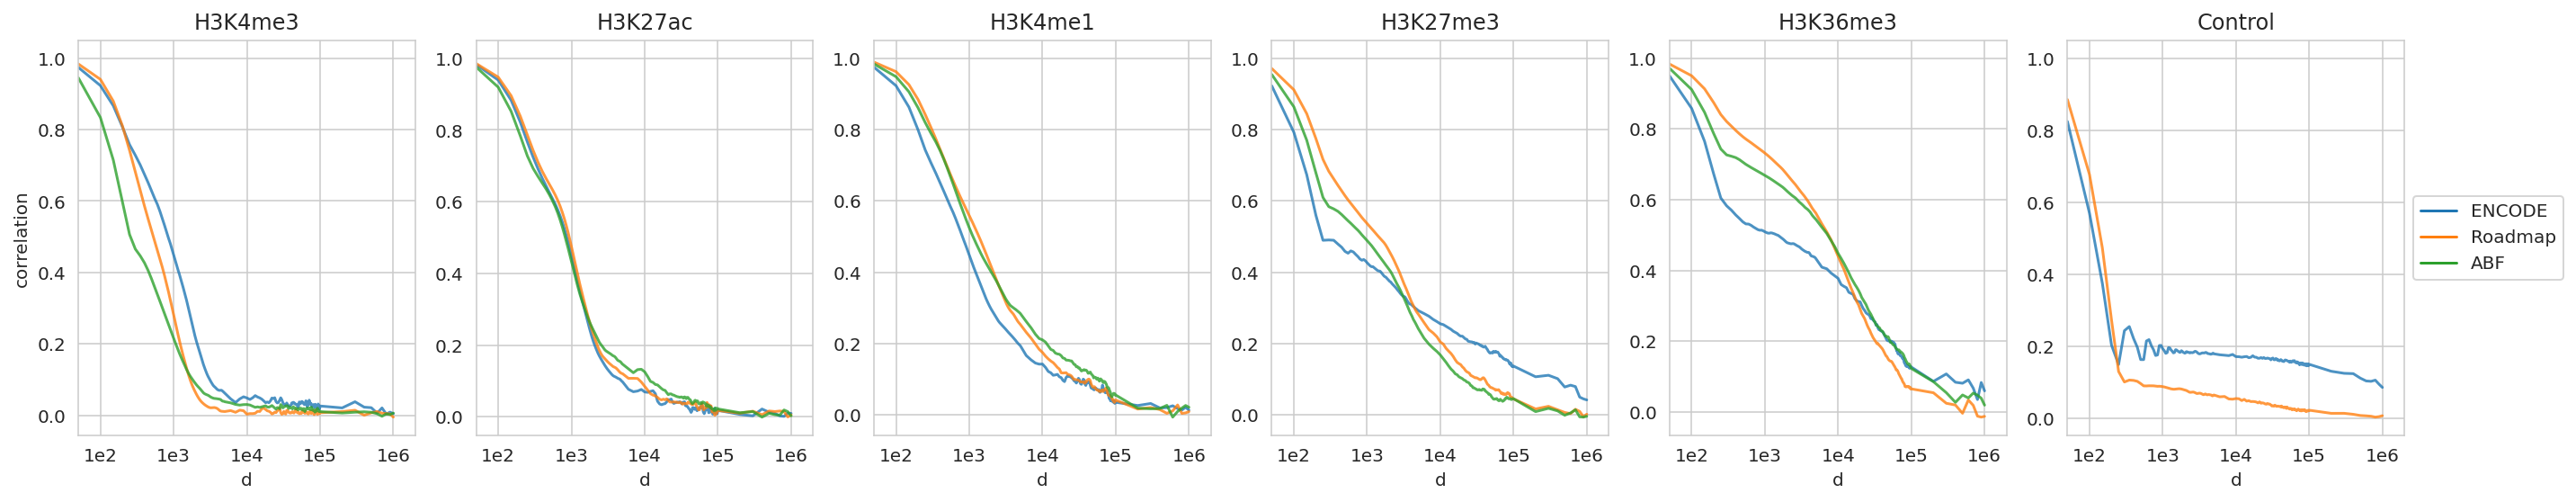

In [38]:
t = summary[['dataset','modification', 'd', 'correlation']].groupby(['dataset', 'modification', 'd']).mean().reset_index()

plt.figure(figsize=(20, 4))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'Control']):
    ax = axs[i]
    g_results = sns.lineplot(data=t[t['modification'] == m], x="d", y="correlation", hue='dataset', ax=ax,
                             hue_order=['ENCODE', 'Roadmap', 'ABF'], alpha=0.8)
    ticks = ['1e2', '1e3', '1e4', '1e5', '1e6']
    g_results.set(xscale='log')
    g_results.set(xticks=[float(t) for t in ticks])
    g_results.set(xticklabels=ticks)
    ax = g_results.axes
    ax.title.set_text(f'{m}')
    ax.set_xlim(50, 2_000_000)
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.show()

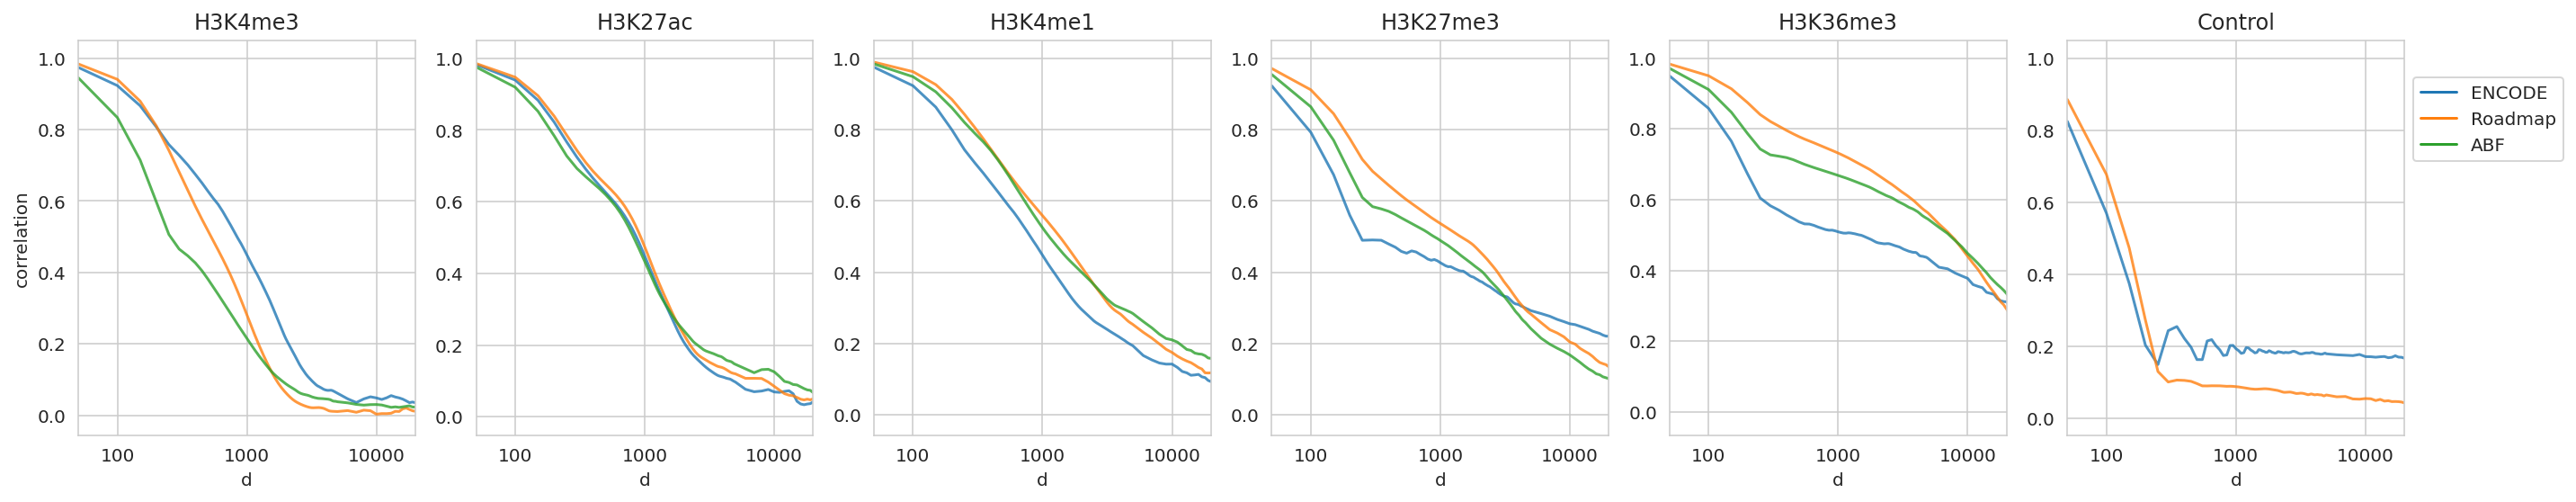

In [39]:
plt.figure(figsize=(20, 4))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'Control']):
    ax = axs[i]
    g_results = sns.lineplot(data=t[t['modification'] == m], x="d", y="correlation", hue='dataset', ax=ax,
                             hue_order=['ENCODE', 'Roadmap', 'ABF'], alpha=0.8)
    ticks = [100, 1000, 10_000]
    g_results.set(xscale='log')
    g_results.set(xticks=ticks)
    g_results.set(xticklabels=ticks)
    ax = g_results.axes
    ax.title.set_text(f'{m}')
    ax.set_xlim(50, 20_000)
    # ax.set_ylim(0, 0.8)
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.show()


## Wiggle and noise mix

In [57]:
WIGGLE_MIX_PATH = os.path.expanduser('~/data/2023_GSE26320_wiggle_mix')
WIGGLE_MIX_BW_PATH = WIGGLE_MIX_PATH + '/bwext'

! mkdir {WIGGLE_MIX_PATH}/pics

mkdir: cannot create directory ‘/home/jetbrains/data/2023_GSE26320_wiggle_80_100/pics’: File exists


In [58]:
df_correlations_wiggle_mix = compute_autocorrelations(['mix', 'wiggle', 'Input'], ['GM12878'], [''],
                                                      {'chr22': CHROM_SIZES['chr22']},
                                                      BIN, DS, bwpath=WIGGLE_MIX_BW_PATH)
df_correlations_wiggle_mix

  0%|          | 0/3 [00:00<?, ?it/s]

mix GM12878  GSM646316_GM12878_H3K27ac_rep1_mix_ext.bw
Computing binned coverage correlations
Signal coverage mln 1730.700136


  0%|          | 0/1 [00:00<?, ?it/s]

Computing mix GM12878 binned 50bp coverage correlations on chr chr22 50818468
wiggle GM12878  GSM646316_GM12878_H3K27ac_rep1_wiggle_80_100_ext.bw
Computing binned coverage correlations
Signal coverage mln 1708.1593


  0%|          | 0/1 [00:00<?, ?it/s]

Computing wiggle GM12878 binned 50bp coverage correlations on chr chr22 50818468
Input GM12878  GSM646332_GM12878_Input_rep1_ext.bw
Computing binned coverage correlations
Signal coverage mln 1404.343019


  0%|          | 0/1 [00:00<?, ?it/s]

Computing Input GM12878 binned 50bp coverage correlations on chr chr22 50818468


,modification,cell,replicate,file,chr,d,correlation,pvalue
0,mix,GM12878,,GSM646316_GM12878_H3K27ac_rep1_mix_ext.bw,chr22,0,1.000000,0.000000
1,mix,GM12878,,GSM646316_GM12878_H3K27ac_rep1_mix_ext.bw,chr22,50,0.972065,0.000000
2,mix,GM12878,,GSM646316_GM12878_H3K27ac_rep1_mix_ext.bw,chr22,100,0.915685,0.000000
3,mix,GM12878,,GSM646316_GM12878_H3K27ac_rep1_mix_ext.bw,chr22,150,0.851984,0.000000
4,mix,GM12878,,GSM646316_GM12878_H3K27ac_rep1_mix_ext.bw,chr22,200,0.785440,0.000000
...,...,...,...,...,...,...,...,...
610,Input,GM12878,,GSM646332_GM12878_Input_rep1_ext.bw,chr22,600000,0.001446,0.444543
611,Input,GM12878,,GSM646332_GM12878_Input_rep1_ext.bw,chr22,700000,-0.003046,0.107156
612,Input,GM12878,,GSM646332_GM12878_Input_rep1_ext.bw,chr22,800000,0.003374,0.074357
613,Input,GM12878,,GSM646332_GM12878_Input_rep1_ext.bw,chr22,900000,0.001388,0.462930


In [59]:
df_correlations_wiggle_mix.loc[df_correlations_wiggle_mix['file'].str.contains('mix'), 'modification'] = 'H3K27ac mix'
df_correlations_wiggle_mix.loc[df_correlations_wiggle_mix['file'].str.contains('wiggle'), 'modification'] = 'H3K27ac wiggle'

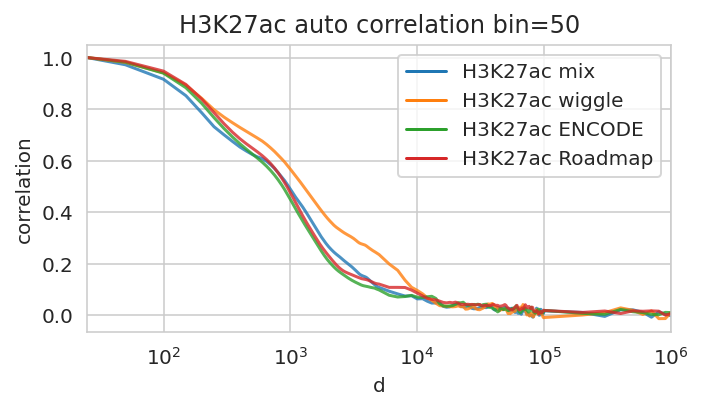

In [60]:
encode_k27ac = summary[(summary['modification'] == 'H3K27ac') & (summary['dataset'] == 'ENCODE')].copy()
encode_k27ac['modification'] = 'H3K27ac ENCODE'
roadmap_k27ac = summary[(summary['modification'] == 'H3K27ac') & (summary['dataset'] == 'Roadmap')].copy()
roadmap_k27ac['modification'] = 'H3K27ac Roadmap'
df_correlations_wiggle_mix['dataset'] = 'wiggle_mix'
t = pd.concat([df_correlations_wiggle_mix, encode_k27ac, roadmap_k27ac]).reset_index(drop=True)
# t = pd.concat([encode_k27ac, roadmap_k27ac]).reset_index(drop=True)

t = t[['dataset','modification', 'd', 'correlation']].groupby(['dataset', 'modification', 'd']).mean().reset_index()
plt.figure(figsize=(5, 3))
# plt.figure(figsize=(10, 6))
ax = plt.axes()
# Show aggregated data, since we don't want error plots
t.loc[t['d'] == 0, 'd'] = BIN / 2
g_results = sns.lineplot(data=t, x="d", y="correlation", hue="modification",
                         hue_order=['H3K27ac mix', 'H3K27ac wiggle', 'H3K27ac ENCODE', 'H3K27ac Roadmap'],
                         alpha=0.8)
# ticks = [10, 100, 1000, 10_000, 100_000, 1_000_000]
# ticks = [1, 20, 50, 100, 200, 500, 1000, 2000, 5000,
#          10_000, 20_000, 50_000, 100_000, 200_000, 500_000, 1_000_000]

g_results.set(xscale='log')
# g_results.set(xticks=ticks)
# g_results.set(xticklabels=ticks)
ax.title.set_text(f'H3K27ac auto correlation bin={BIN}')
ax.set_xlim(BIN / 2, 1_000_000)
ax.legend(loc='upper right')
plt.tight_layout()
# plt.savefig(f'{WIGGLE_MIX_PATH}/pics/signal_correlation.pdf', bbox_inches='tight', dpi=300)
plt.show()

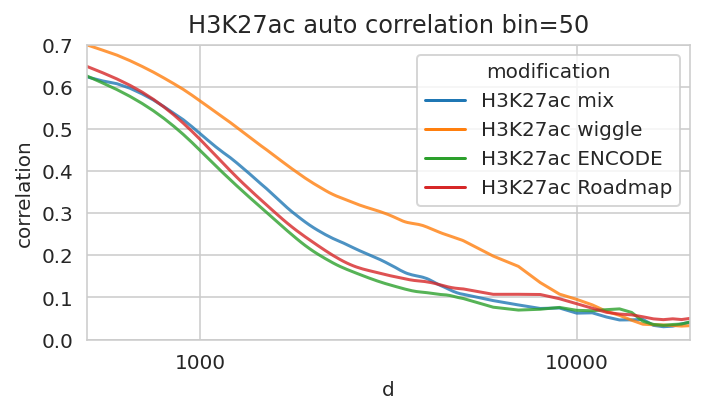

In [61]:
# plt.figure(figsize=(10, 6))
plt.figure(figsize=(5, 3))
g_results = sns.lineplot(data=t, x="d", y="correlation", hue="modification",
                         hue_order=['H3K27ac mix', 'H3K27ac wiggle', 'H3K27ac ENCODE', 'H3K27ac Roadmap'],
                         alpha=0.8)
ticks = [1000, 10_000]
g_results.set(xscale='log')
g_results.set(xticks=ticks)
g_results.set(xticklabels=ticks)
ax = g_results.axes
ax.title.set_text(f'H3K27ac auto correlation bin={BIN}')
ax.set_xlim(500, 20_000)
ax.set_ylim(0, 0.7)
plt.tight_layout()
# plt.savefig(f'{WIGGLE_MIX_PATH}/pics/signal_correlation_zoom.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Noise mix

In [46]:
ENCODE_NOISE_PATH = os.path.expanduser('~/data/2023_GSE26320_noise')
ENCODE_NOISE_BW_PATH = ENCODE_NOISE_PATH + '/bwext'
! mkdir -p {ENCODE_NOISE_PATH}/pics

In [47]:
df_correlations_noise = compute_autocorrelations(['1mln', '2mln', '5mln', '7mln'], ['GM12878'], ['rep1'],
                                                 {'chr22': CHROM_SIZES['chr22']},
                                                 BIN, DS, bwpath=ENCODE_NOISE_BW_PATH)
df_correlations_noise

  0%|          | 0/4 [00:00<?, ?it/s]

1mln GM12878 rep1 GSM646316_GM12878_H3K27ac_rep1_1mln_noise_ext.bw
Computing binned coverage correlations
Signal coverage mln 1651.295185


  0%|          | 0/1 [00:00<?, ?it/s]

Computing 1mln GM12878 binned 50bp coverage correlations on chr chr22 50818468
2mln GM12878 rep1 GSM646316_GM12878_H3K27ac_rep1_2mln_noise_ext.bw
Computing binned coverage correlations
Signal coverage mln 1895.529335


  0%|          | 0/1 [00:00<?, ?it/s]

Computing 2mln GM12878 binned 50bp coverage correlations on chr chr22 50818468
5mln GM12878 rep1 GSM646316_GM12878_H3K27ac_rep1_5mln_noise_ext.bw
Computing binned coverage correlations
Signal coverage mln 2441.440753


  0%|          | 0/1 [00:00<?, ?it/s]

Computing 5mln GM12878 binned 50bp coverage correlations on chr chr22 50818468
7mln GM12878 rep1 GSM646316_GM12878_H3K27ac_rep1_7mln_noise_ext.bw
Computing binned coverage correlations
Signal coverage mln 2416.593939


  0%|          | 0/1 [00:00<?, ?it/s]

Computing 7mln GM12878 binned 50bp coverage correlations on chr chr22 50818468


,modification,cell,replicate,file,chr,d,correlation,pvalue
0,1mln,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_1mln_noise_ext.bw,chr22,0,1.000000,0.000000e+00
1,1mln,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_1mln_noise_ext.bw,chr22,50,0.898472,0.000000e+00
2,1mln,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_1mln_noise_ext.bw,chr22,100,0.738226,0.000000e+00
3,1mln,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_1mln_noise_ext.bw,chr22,150,0.600387,0.000000e+00
4,1mln,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_1mln_noise_ext.bw,chr22,200,0.471514,0.000000e+00
...,...,...,...,...,...,...,...,...
815,7mln,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_7mln_noise_ext.bw,chr22,600000,0.002598,1.482105e-01
816,7mln,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_7mln_noise_ext.bw,chr22,700000,-0.011304,3.144763e-10
817,7mln,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_7mln_noise_ext.bw,chr22,800000,0.008243,4.479169e-06
818,7mln,GM12878,rep1,GSM646316_GM12878_H3K27ac_rep1_7mln_noise_ext.bw,chr22,900000,0.012101,1.640527e-11


In [48]:
df_correlations_noise.loc[df_correlations_noise['file'].str.contains('1mln'), 'modification'] = 'H3K27ac_1mln'
df_correlations_noise.loc[df_correlations_noise['file'].str.contains('2mln'), 'modification'] = 'H3K27ac_2mln'
df_correlations_noise.loc[df_correlations_noise['file'].str.contains('5mln'), 'modification'] = 'H3K27ac_5mln'
df_correlations_noise.loc[df_correlations_noise['file'].str.contains('7mln'), 'modification'] = 'H3K27ac_7mln'

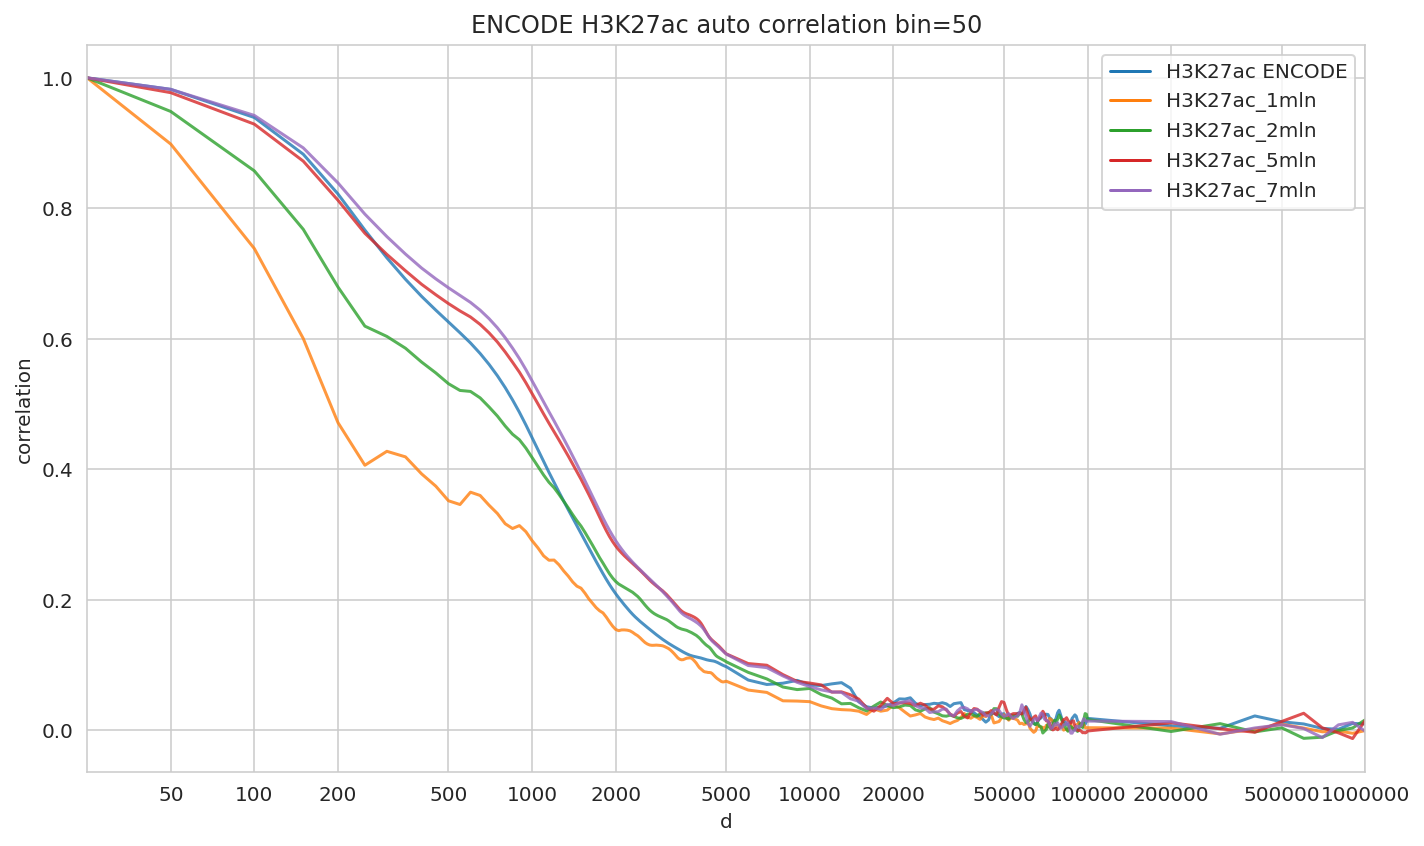

In [49]:
df_correlations_noise['dataset'] = 'mix_noise'
t = pd.concat([df_correlations_noise,
               encode_k27ac,
               # df_correlations_wiggle_mix[(df_correlations_wiggle_mix['modification'] == 'H3K27ac_wiggle')|
               #                            (df_correlations_wiggle_mix['modification'] == 'H3K27ac_mix')]
               ]).reset_index(drop=True)
plt.figure(figsize=(10, 6))
# plt.figure(figsize=(5, 3))
ax = plt.axes()
# Show aggregated data, since we don't want error plots
t.loc[t['d'] == 0, 'd'] = BIN / 2
t = t[['dataset', 'modification', 'd', 'correlation']].groupby(['dataset', 'modification', 'd']).mean().reset_index()
g_results = sns.lineplot(data=t, x="d", y="correlation", hue="modification", alpha=0.8)
# ticks = [10, 100, 1000, 10_000, 100_000, 1_000_000]
ticks = [1, 20, 50, 100, 200, 500, 1000, 2000, 5000,
         10_000, 20_000, 50_000, 100_000, 200_000, 500_000, 1_000_000]

g_results.set(xscale='log')
g_results.set(xticks=ticks)
g_results.set(xticklabels=ticks)
ax.title.set_text(f'ENCODE H3K27ac auto correlation bin={BIN}')
ax.set_xlim(BIN / 2, 1_000_000)
ax.legend(loc='upper right')
plt.tight_layout()
# plt.savefig(f'{WIGGLE_MIX_PATH}/pics/signal_correlation.pdf', bbox_inches='tight', dpi=300)
plt.show()

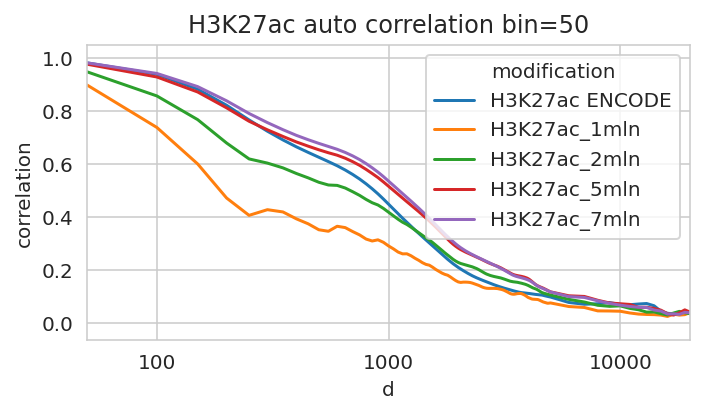

In [50]:
# plt.figure(figsize=(10, 6))
plt.figure(figsize=(5, 3))
ax = plt.axes()
g_results = sns.lineplot(data=t, x="d", y="correlation", hue="modification") 
ticks = [100, 1000, 10_000]
g_results.set(xscale='log')
g_results.set(xticks=ticks)
g_results.set(xticklabels=ticks)
ax.title.set_text(f'H3K27ac auto correlation bin={BIN}')
ax.set_xlim(50, 20_000)
plt.tight_layout()
# plt.savefig(f'{WIGGLE_MIX_PATH}/pics/signal_correlation_zoom.pdf', bbox_inches='tight', dpi=300)
plt.show()

# END